# Proyectando el comportamiento de la soja

_Competencia Metadata 2019_  
_https://metadata.fundacionsadosky.org.ar/competition/11/_

## Objetivos
1. Lograr el mejor fit para la serie de retornos simples diarios $\frac{p_1 - p_0}{p_0}$. Serie desde la Fecha de Cierre del Concurso (FCC 29/9/2019) + 10 días hábiles.
2. Lograr la mejor proyección para el último valor de la serie contínua de la soja al fin del concurso. Cierra a la FCC + 10 días hábiles.
3. Lograr el mejor fit para la serie de retornos simples diarios de 4 semanas. Desde FCC - 10 días hábiles, hasta FCC + 10 días hábiles.

## Dataset oficial

[Dataset](https://drive.google.com/file/d/1r0DWiUIQ_N13HeervqrUhbV3TjUlEe4Q/view?usp=sharing) la información que contiene este archivo es hasta el día 29/8/2019. Por ende para calcular el score circunstancial se entiende que usted está proyectando hasta el día 12/9/2019. Esta información se irá actualizando todas las semanas hasta la última actualización que será el día 27/9/2019.

## Descripción

- `Fecha` Fecha de referencia para el precio.
- `Open` Precio de apertura del día.
- `High` Precio máximo del día.
- `Low` Precio mínimo del día.
- `Last` Precio último operado del día.
- `Cierre` Precio de ajuste del día. **Ésta es la serie a proyectarse.**
- `Aj.Dif.` Diferencia nominal respecto del día anterior.
- `Mon` Moneda de denominación del contrato.
- `Oi.Vol` Interés abierto del contrato.
- `Oi.Dif.` Diferencia del interés abierto respecto del día anterior.
- `Vol.Ope.` Volumen Operado medido en contratos.
- `Unidad` Unidad en que se miden los contratos.
- `DolarB.N.` Precio del dólar del Banco de la Nación Argentina.
- `DolarItau` Precio del dólar del Banco Itaú.
- `Diff.Sem` Diferencia Semanal.

## Métrica

La calificación de la solución propuesta se hace con el error absoluto medio ([MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) por su sigla en inglés) y se calcula como el promedio de las diferencias (en valor absoluto) entre las respuestas enviadas y las correctas:

$$ MAE = \frac{1}{n} \sum_{j=1}^{n} |y_j - \hat{y_j} | $$

## Formato de respuesta

Debe enviarse un archivo en formato `csv` sin encabezado con 4 columnas y 20 filas.

- Primer columna debe contener al número de fila (int).
- Segunda columna debe contener las fechas correspondientes en formato "dd/mm/YYYY."
- Tercer columna debe contener los retornos (float).
- Cuarta columna debe contener el precio (cierre del día) del contrato (float).

Las filas 1 a 10 corresponden a FCC - 10 días hábiles y las filas 11 a 20 corresponden a la proyección futura.

## Exploración

In [3]:
%config InlineBackend.figure_format = 'retina'

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import pyflux as pf
import seaborn as sns
import statsmodels.api as sm

warnings.simplefilter('ignore')
register_matplotlib_converters()

In [4]:
sns.set(rc={'figure.figsize': (12,8)})

In [5]:
data_dir = 'data/'

In [6]:
date_parser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y 12:00:00 a.m.")
df = pd.read_csv(os.path.join(data_dir, 'datasetRofex2.csv'),
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)

In [7]:
df.head()

,Id,Open,High,Low,Last,Cierre,Aj.Dif.,Mon.,OI.Vol.,OI.Dif.,Vol.Ope.,Unidad,DolarB.N.,DolarItau.,Dif.Sem
Fecha,,,,,,,,,,,,,,,
2004-01-05,1,0.0,0.0,0.0,0.0,221.0,13.0,D,0.0,0.0,0,TONS,2.920,2.905,-221.0
2004-01-06,2,0.0,0.0,0.0,0.0,221.0,0.0,D,0.0,0.0,0,TONS,2.880,2.870,-221.0
2004-01-07,3,0.0,0.0,0.0,0.0,219.0,-2.0,D,0.0,0.0,0,TONS,2.865,2.882,-219.0
2004-01-08,4,0.0,0.0,0.0,0.0,220.0,1.0,D,0.0,0.0,0,TONS,2.887,2.884,-220.0
2004-01-09,5,0.0,0.0,0.0,0.0,220.0,0.0,D,0.0,0.0,0,TONS,2.892,2.900,-220.0


Empezamos con un plot del precio de cierre en cada día.

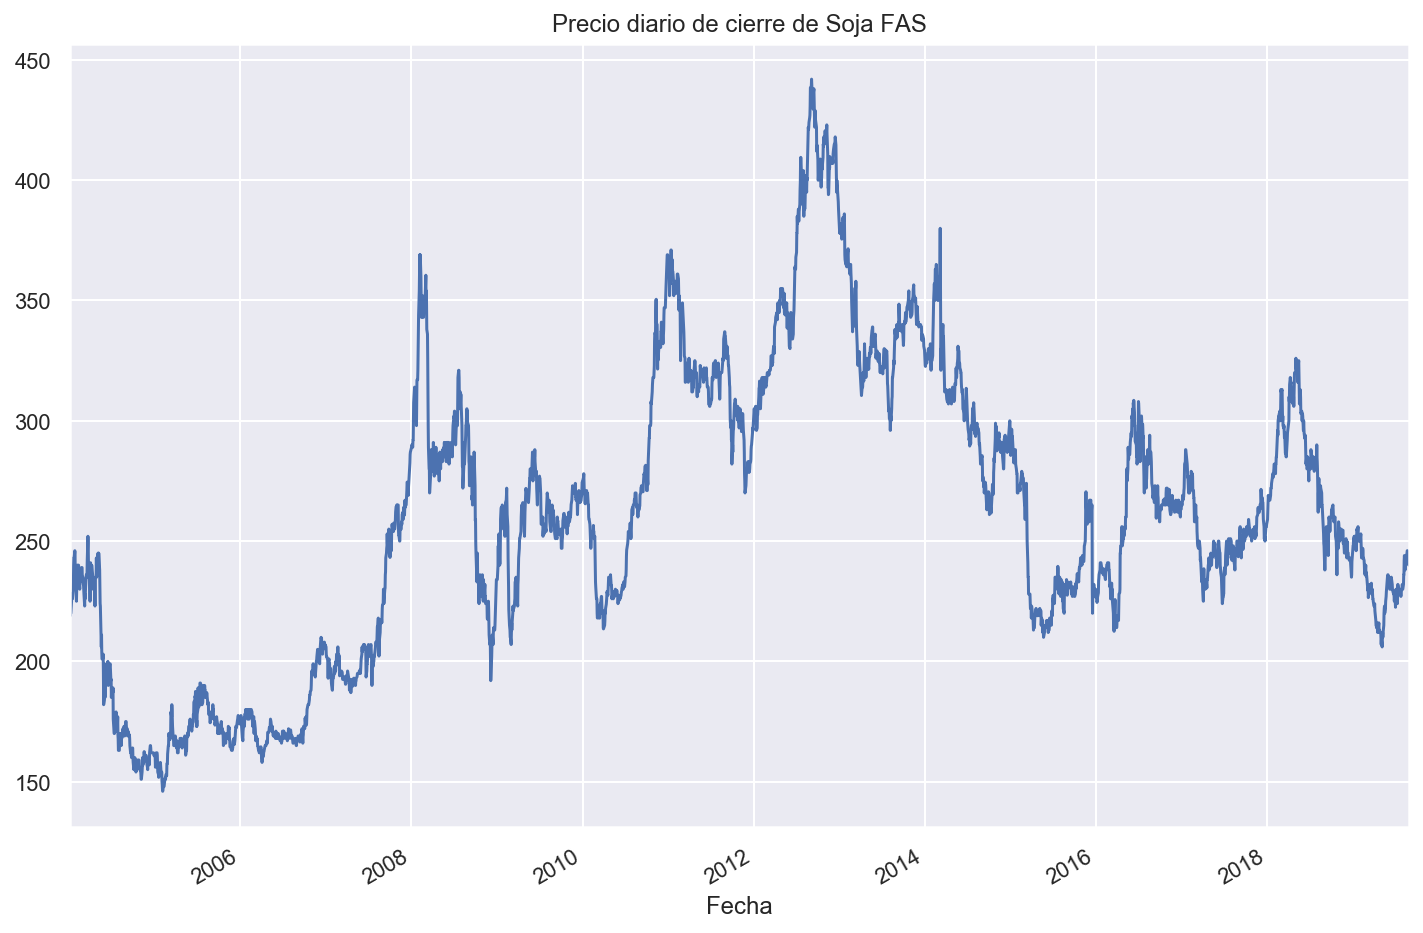

In [8]:
df['Cierre'].plot(title='Precio diario de cierre de Soja FAS');

El gráfico sugiere que se trata de una serie no estacionaria, con un *trend* marcado. Podemos confirmar esto con un gáfico de autocorrelación.

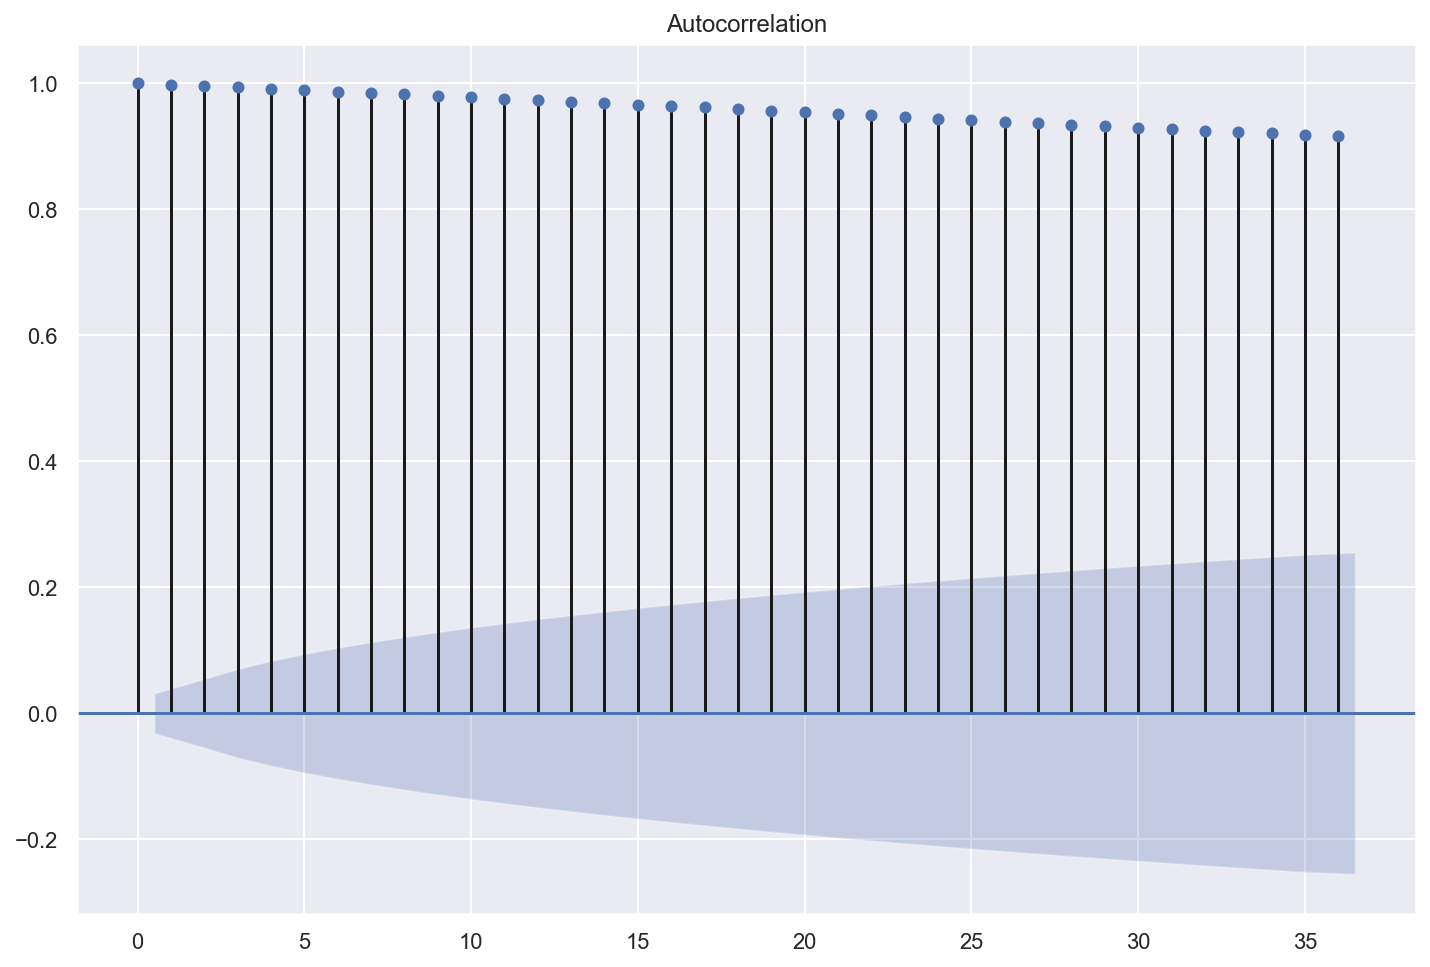

In [14]:
sm.graphics.tsa.plot_acf(df['Cierre']);

Si la serie fuera estacionaria, uno esperaría que la autocorrelación decreciera rápidamente al aumentar el *lag*, pero esto no es así. Nuestro objetivo, sin embargo, no es predecir el precio de cierre sino el retorno diario, que es (casi) la serie diferenciada. Veamos la autocorrelación de estos retornos.

In [9]:
df['retorno'] = df['Cierre'].pct_change()

In [10]:
df['log_retorno'] = np.log(df['Cierre'] / df['Cierre'].shift(1))

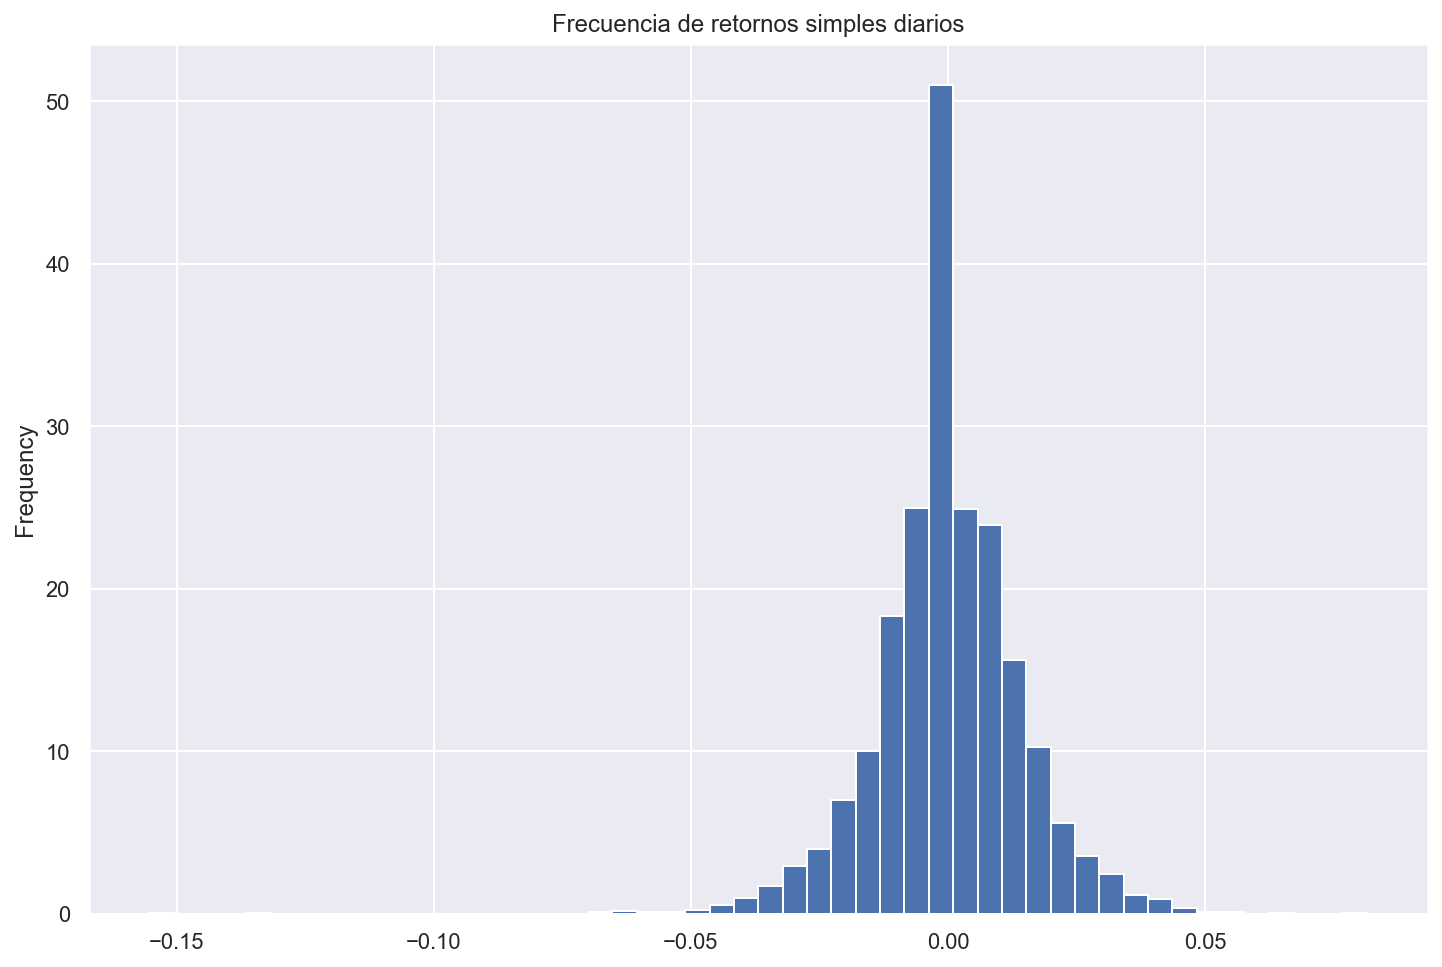

In [11]:
df['retorno'].plot(kind='hist', bins=50, title='Frecuencia de retornos simples diarios', density=True);

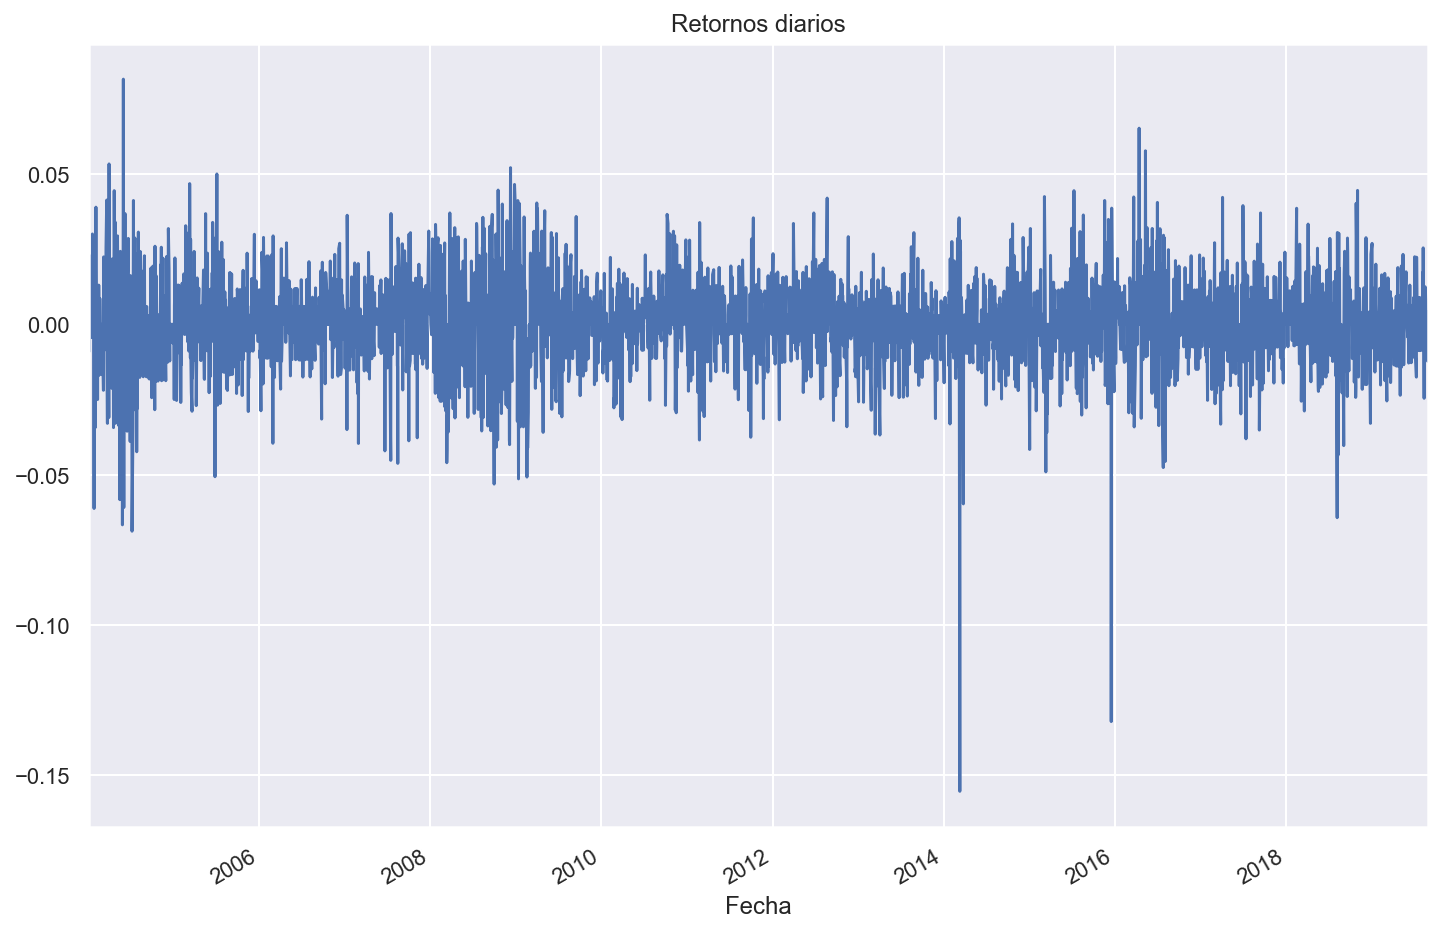

In [19]:
df['retorno'].dropna().plot(title='Retornos diarios');

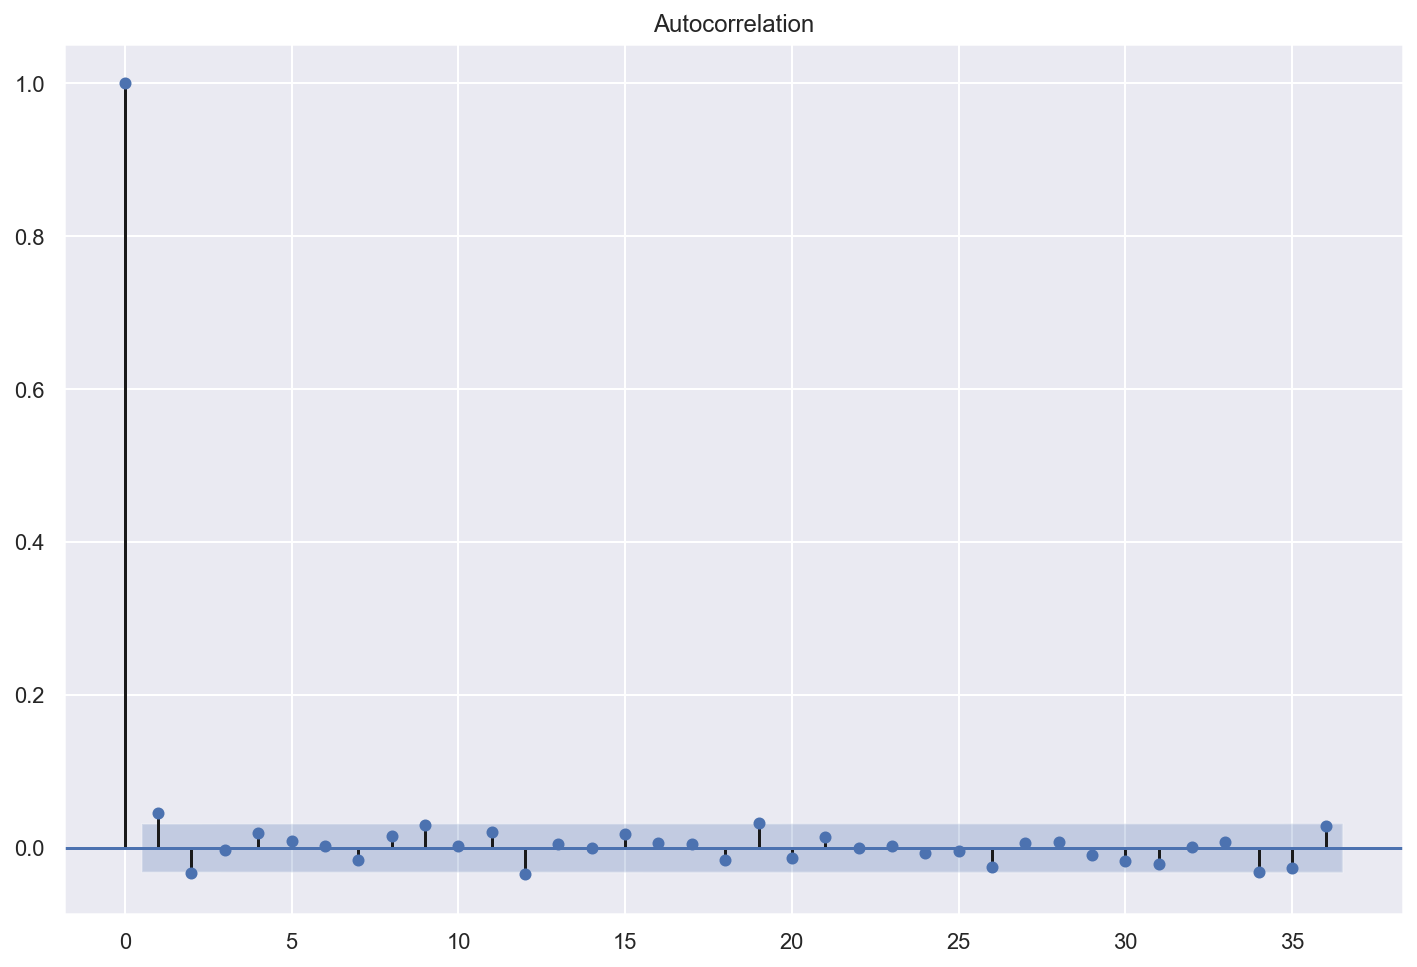

In [16]:
sm.graphics.tsa.plot_acf(df['retorno'].dropna());

Se ve claramente que al tomar retornos, la autocorrelación baja muy rápido al aumentar el lag, lo que nos dice que estamos en presencia de un proceso más estacionario. 

Nuestra herramienta principal para la predicción de los retornos será una combinación de los métodos ARIMA y GARCH. A continuación damos una breve explicación de ellos. 

[ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) (*Autoregressive integrated moving average*) es un modelo aplicado a series de tiempo que considera al valor actual de la serie como una regresión sobre valores previos y al error de regresión como una combinación lineal de errores previos. Más precisamente, si la serie la notamos $\{Y_t\}_{t \in \mathbb{N}}$, el valor a tiempo $t$ se modela por $Y_t = \phi_0 + \sum_{i=1}^{p}{\phi_i Y_{t-i}} + \sum_{i=1}^{q}{\theta_i \varepsilon_{t-i}} + \varepsilon_t$, donde los $\varepsilon_i$ con $i\neq t$ son errores de regresión, $\varepsilon_t$ es [ruido blanco](https://es.wikipedia.org/wiki/Ruido_blanco) y los coeficientes $\phi_i$ y $\theta_i$ se ajustan típicamente a través de métodos estadísticos. La cantidad de pasos en el pasado que se consideran forma un par de hiperparámetros del modelo (los números $p$ y $q$), con un tercero (generalmente notado $d$) que determina cuántas veces diferenciar la serie antes de aplicarle lo anterior. Todo esto da un método $ARIMA(p,d,q)$. En nuestro caso tomamos $d=0$ porque aplicamos el método a los retornos, que ya son lo suficientemente estacionarios. Si lo quisiéramos aplicar al precio de cierre tomaríamos $d=1$ para diferenciarlo, obteniendo una serie muy similar a los retornos pero a otra escala (porque en cada paso no estaríamos diviendo por el precio del día anterior).

[GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) (*Generalized autoregressive conditional heteroskedasticity*) es otro modelo aplicado a series de tiempo para describir la varianza del error entre el valor observado y el que se había previsto (en nuestro caso, el término $\varepsilon_t$ que se consideraba ruido blanco). Típicamente esta varianza se escribe como combinación lineal de sus valores previos.

Juntando estas dos cosas, nuestro modelo se reduce a descomponer la serie de tiempo $Y_t$ como:

$$\begin{equation} 
Y_t = \mu_t + u_t 
\end{equation}$$

con $\mu_t$ la expresión dada por ARIMA (menos el término $\varepsilon_t$) y $u_t = \sigma_t \varepsilon_t$ el ruido, cuya varianza $\sigma^2_t$ se modela vía GARCH, escribiéndola como

$$\begin{equation}
\sigma^2_t = \alpha_0 + \sum_{i=1}^{s}{\alpha_i u_{t-i}^2} + \sum_{i=1}^{r}{\beta_i \sigma_{t-i}^2 }
\end{equation}$$

nuevamente para coeficientes $\alpha_i$, $\beta_i$ que deben ajustarse apropiadamente e hiperparámetros $r$ y $s$.

En realidad, nuestro modelo va a usar SARIMA (*Seasonal* ARIMA), una variante que permite controlar por componentes estacionales, pero las ideas son las mismas. En este caso consideramos una estacionalidad de seis meses correspondiente al ciclo de la soja. Para ver esto mejor, graficamos la descomposición estacional de nuestra serie de retornos por períodos de seis meses (aproximadamente 182 días).

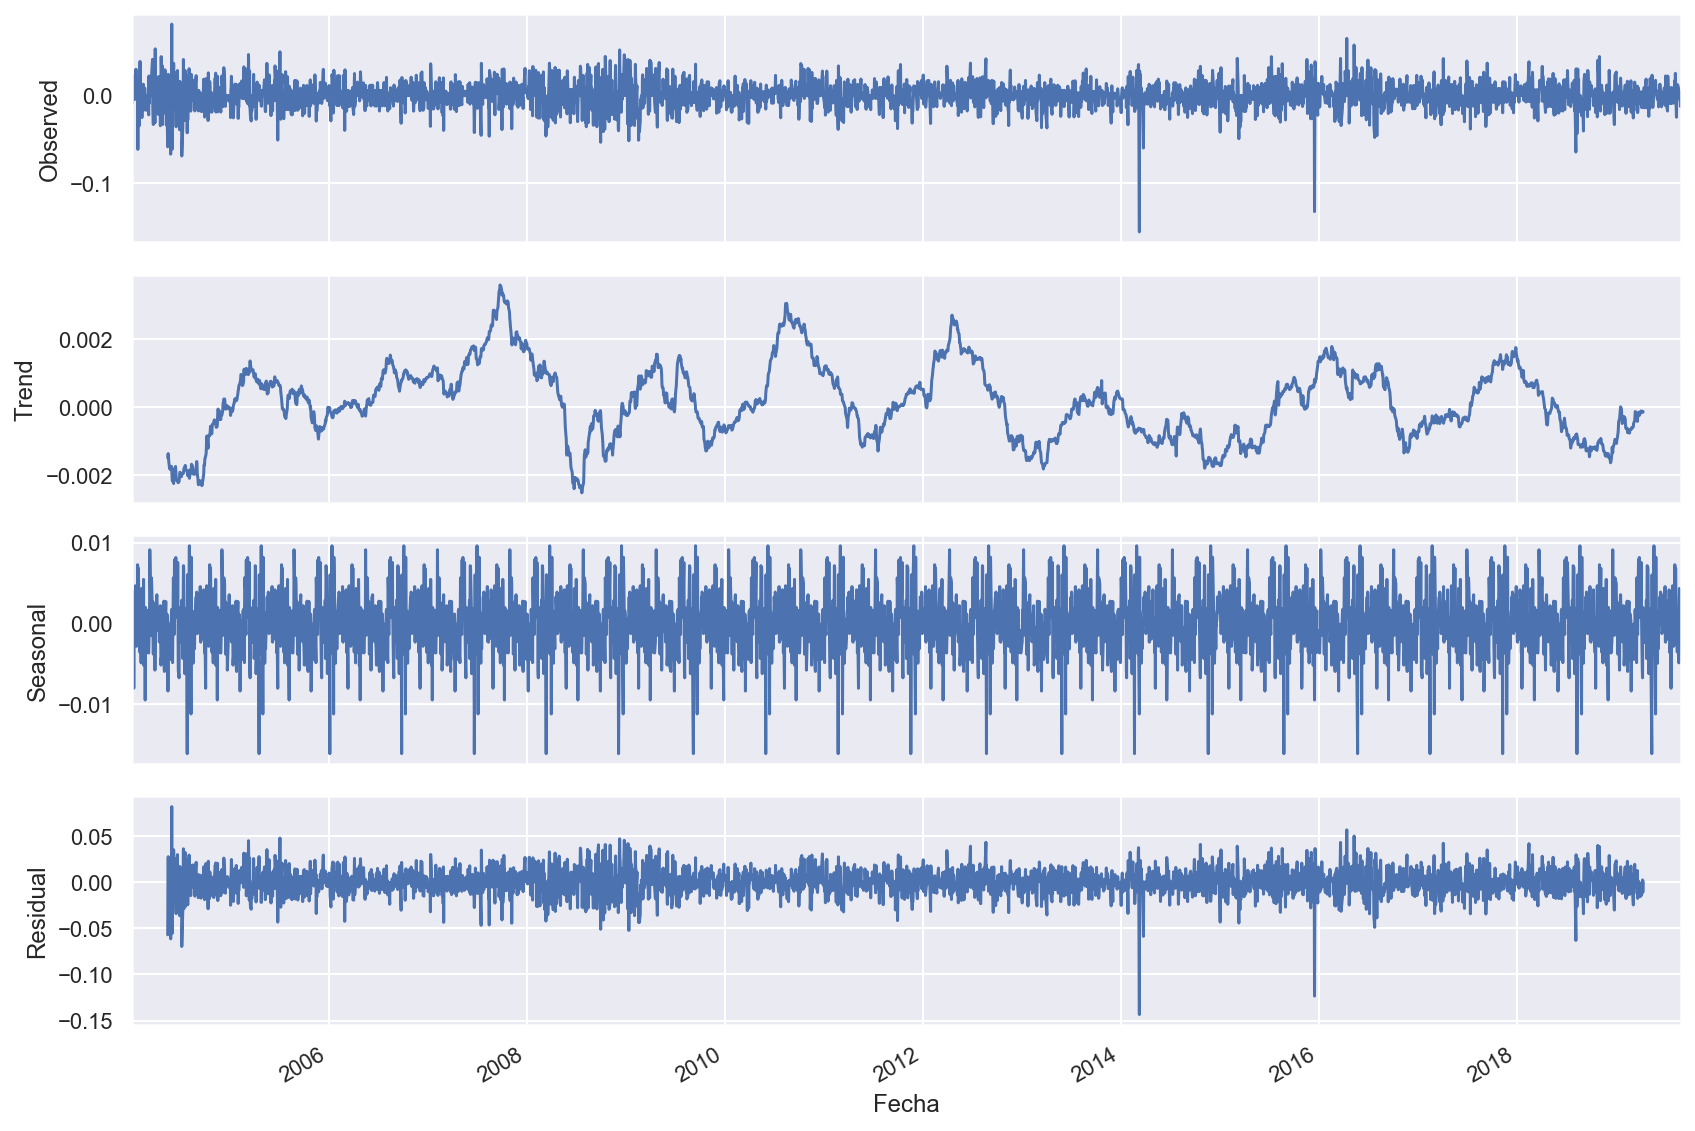

In [43]:
decomposition_half_year_ret = sm.tsa.seasonal_decompose(df['retorno'].dropna(), freq=182)
decomposition_half_year_ret.plot();

En el gráfico vemos un *trend* muy pequeño alrededor del cero (que nos sugiere que el retorno promedio es siempre cercano a cero) y una estacionalidad leve, que no llega a tener un impacto muy grande en el valor total de la serie pero igual puede ser tenida en cuenta.

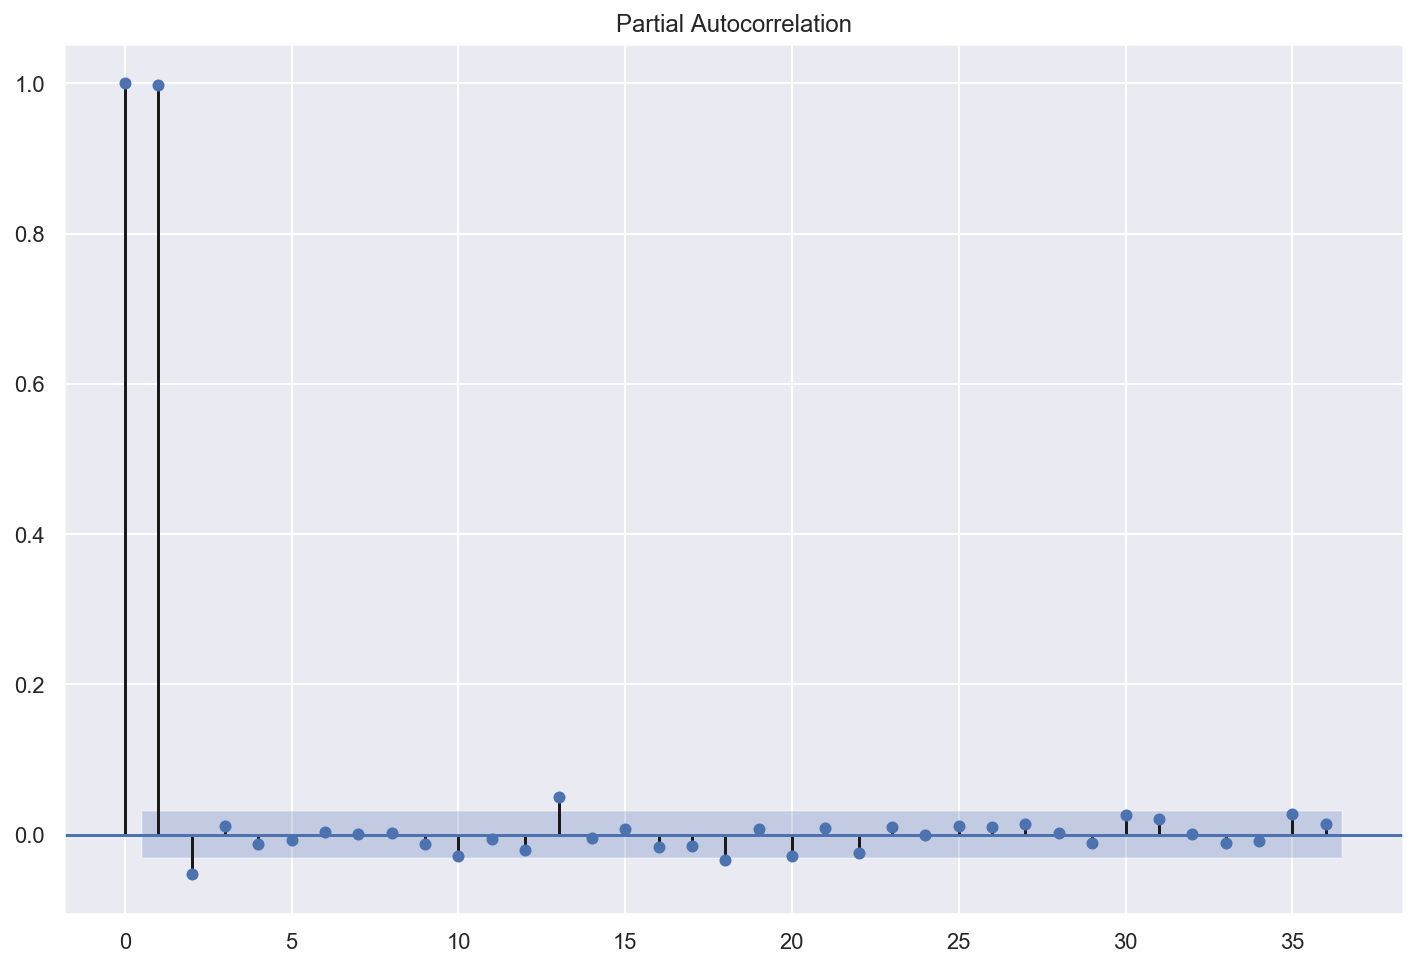

In [10]:
sm.graphics.tsa.plot_pacf(df['Cierre']);

In [5]:
model = pf.ARIMA(data=df, target='Cierre', ar=2, ma=0, family=pf.Normal())

In [6]:
print(model.latent_variables)

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Constant                  Normal          mu0: 0, sigma0: 3         Normal     None      
1        AR(1)                     Normal          mu0: 0, sigma0: 0.5       Normal     None      
2        AR(2)                     Normal          mu0: 0, sigma0: 0.5       Normal     None      
3        Normal Scale              Flat            n/a (non-informative)     Normal     exp       


In [7]:
fit = model.fit('M-H')

Acceptance rate of Metropolis-Hastings is 0.0056
Acceptance rate of Metropolis-Hastings is 0.1067
Acceptance rate of Metropolis-Hastings is 0.138
Acceptance rate of Metropolis-Hastings is 0.16985
Acceptance rate of Metropolis-Hastings is 0.22165
Acceptance rate of Metropolis-Hastings is 0.2845

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2853


In [9]:
fit.summary()

Normal ARIMA(2,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Cierre                              Method: Metropolis Hastings                       
Start Date: 2004-01-07 00:00:00                         Unnormalized Log Posterior: -10601.3758           
End Date: 2019-08-29 00:00:00                           AIC: 21210.75165764952                            
Number of observations: 3852                            BIC: 21235.777048741194                           
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Constant                                 0.4783             0.4467             (0.0029 | 0.6817)        
AR(1)                                    1.

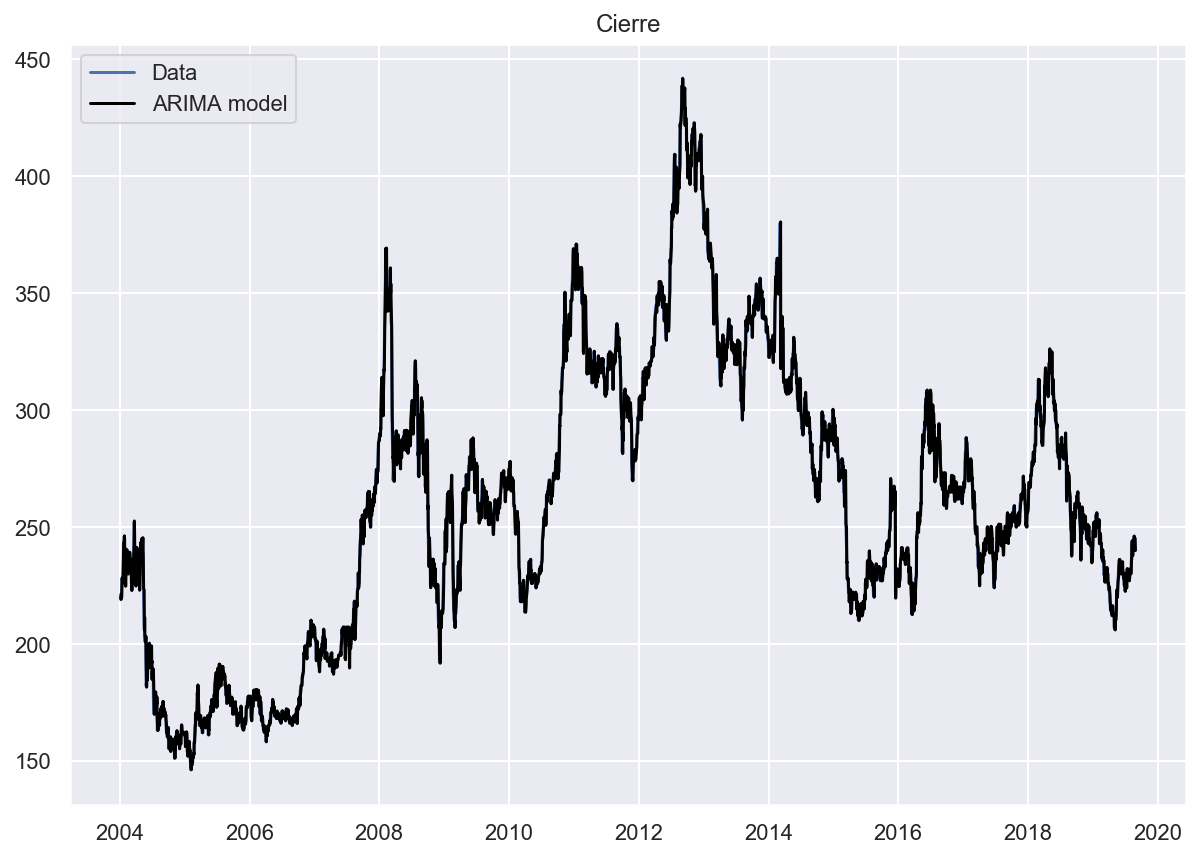

In [10]:
model.plot_fit()

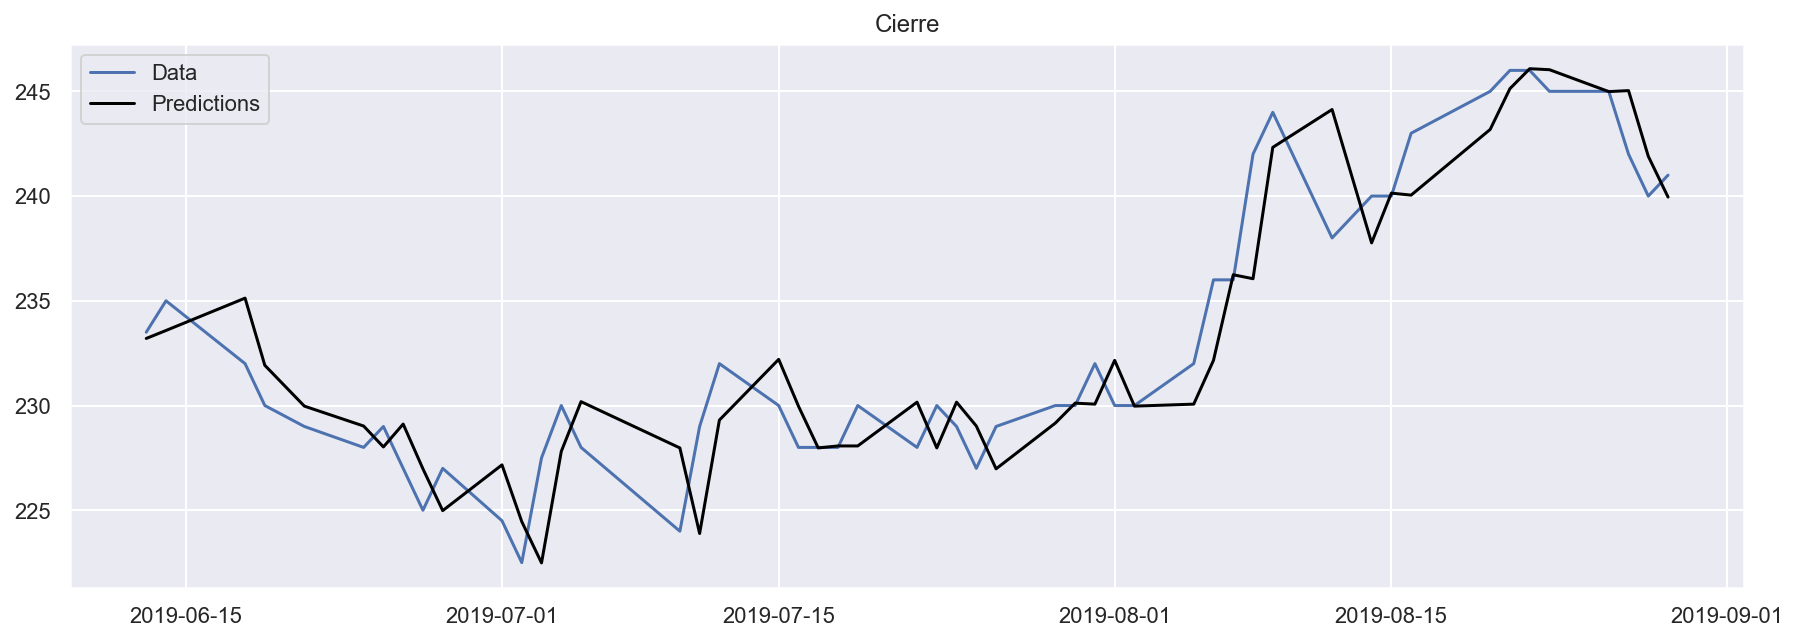

In [11]:
model.plot_predict_is(h=50, figsize=(15,5))

In [15]:
model.data - model.data_original

array([0., 0., 0., ..., 0., 0., 0.])

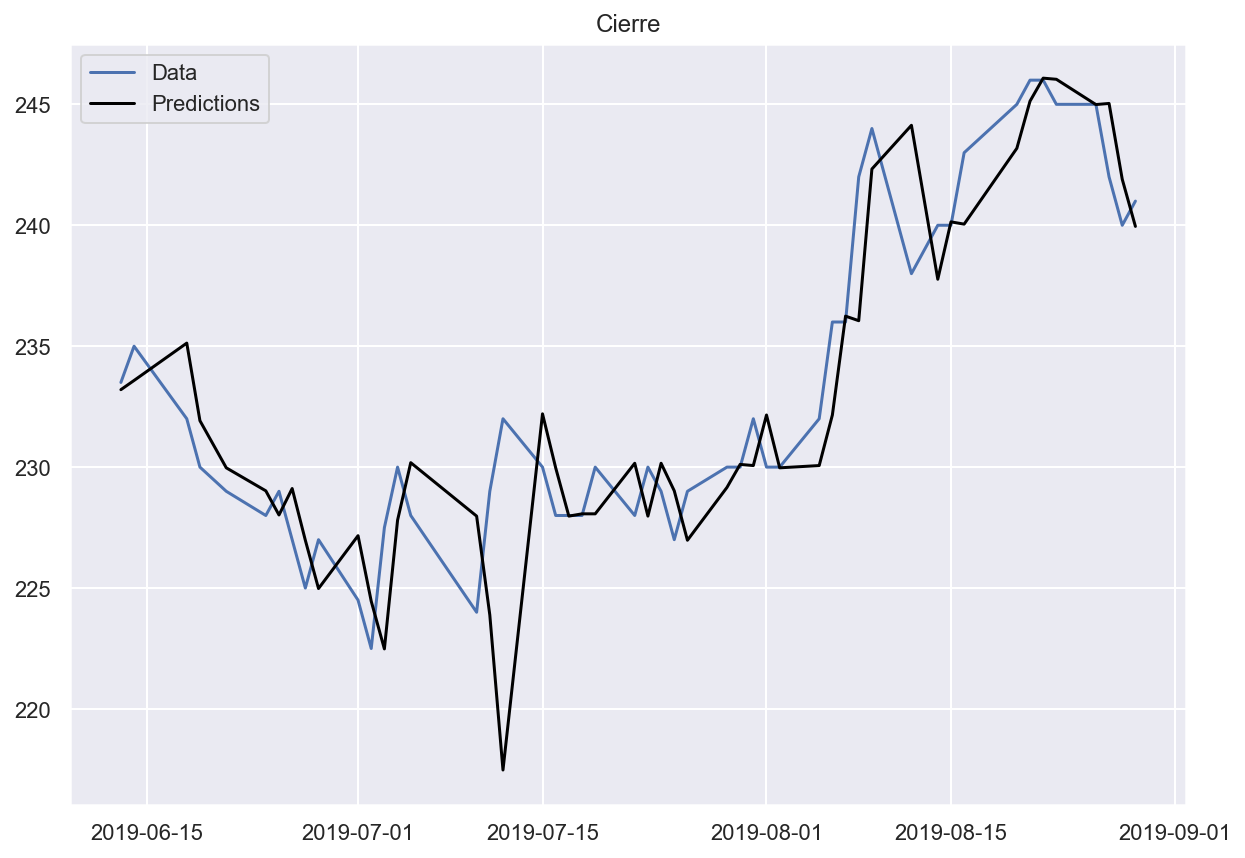

In [8]:
model.plot_predict_is(h=50, fit_once=False);

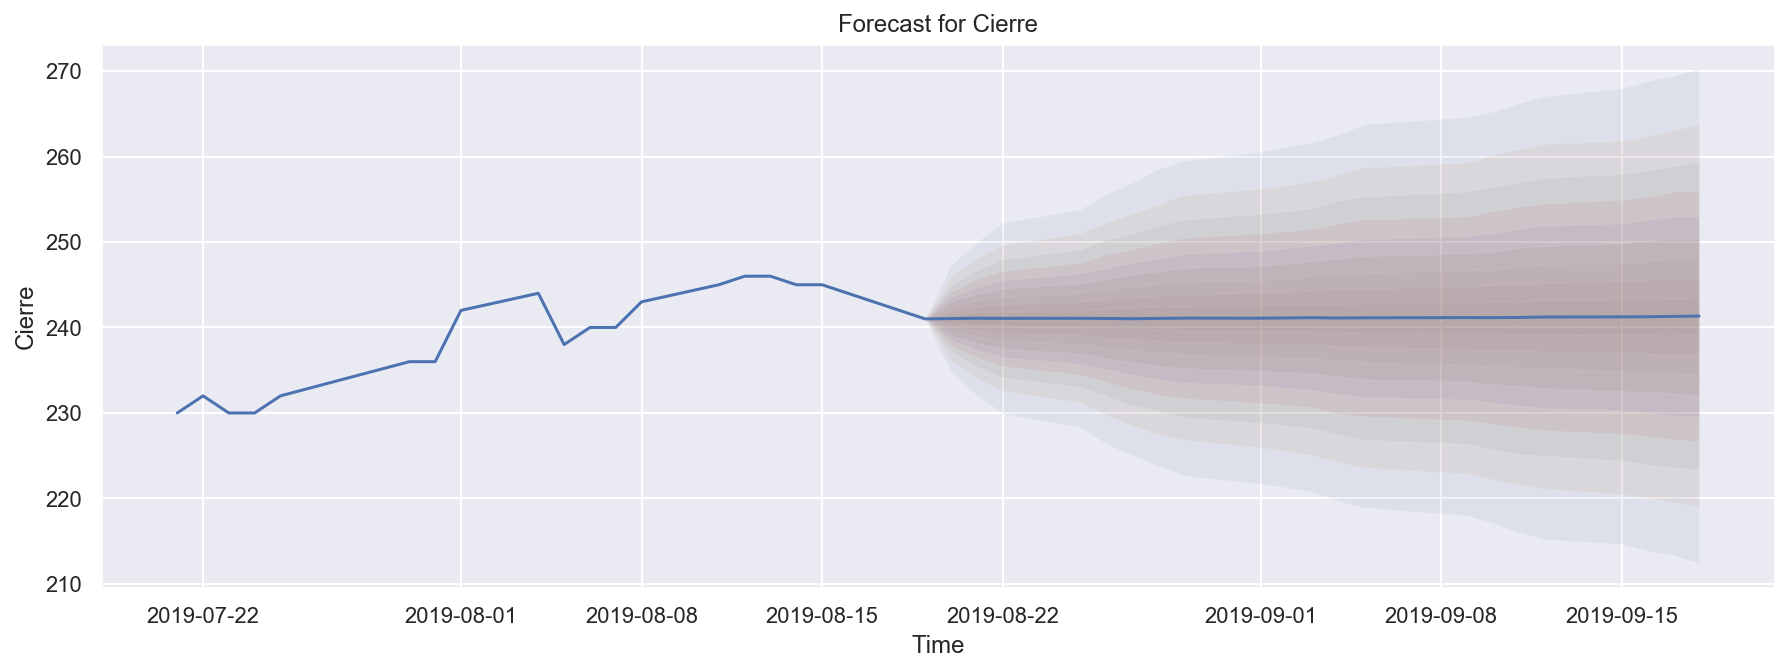

In [17]:
model.plot_predict(h=20, past_values=20, figsize=(15,5))

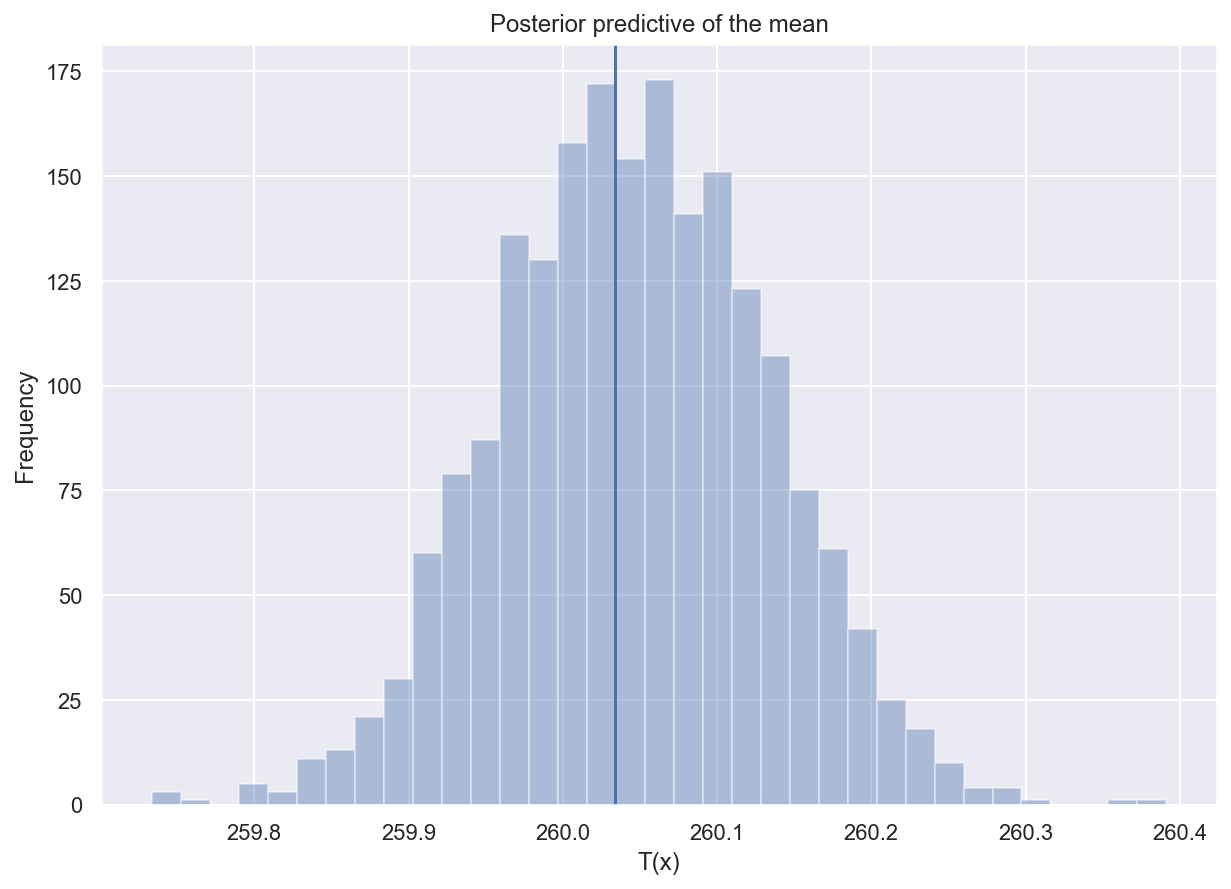

In [18]:
model.plot_ppc(T=np.mean, nsims=2000)

In [19]:
# Workaround for pyflux `plot_z()` method

from scipy.stats import norm
from matplotlib import mlab

mlab.normpdf = norm.pdf

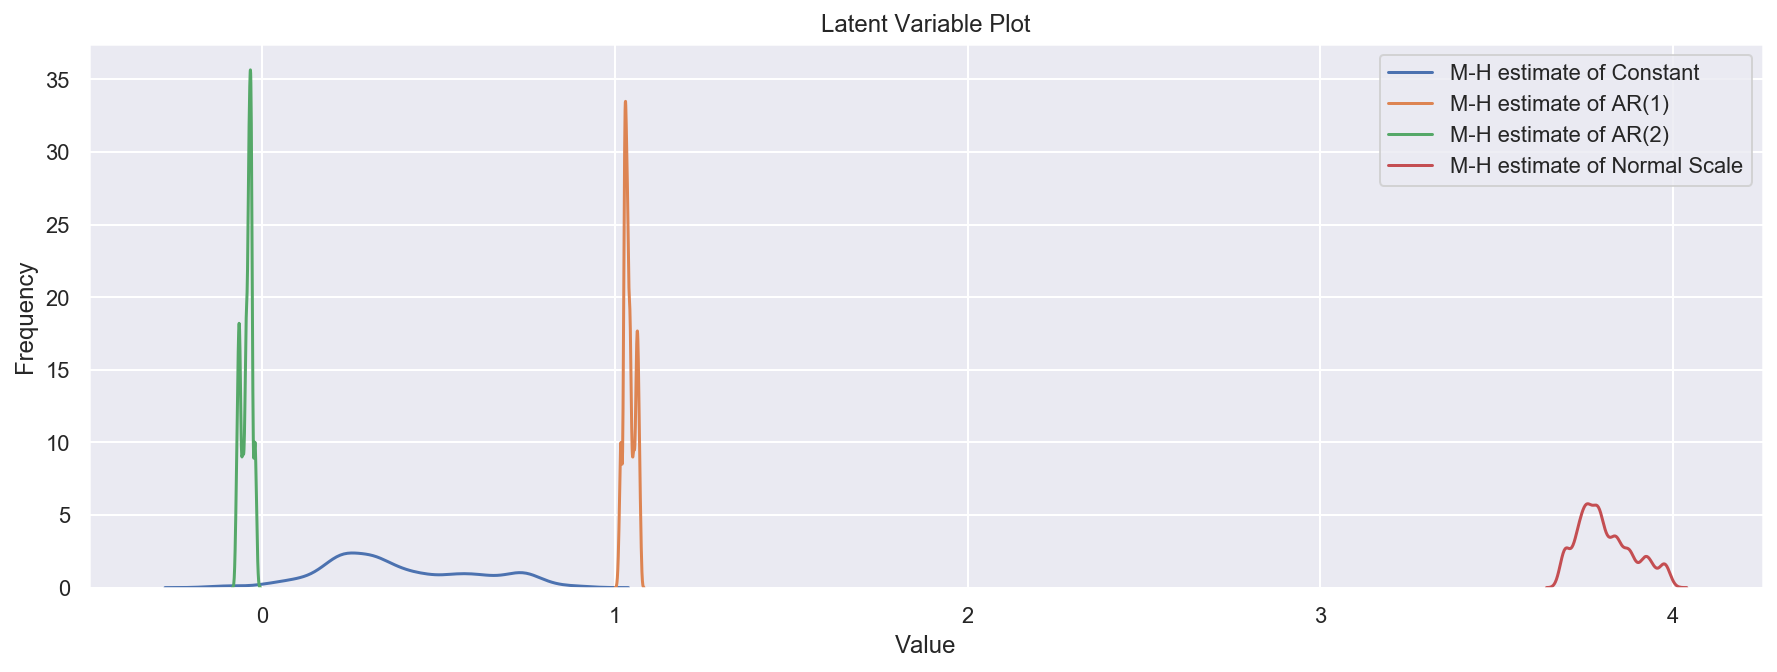

In [20]:
model.plot_z()

In [29]:
decomposition = sm.tsa.seasonal_decompose(df['retorno'].dropna(), freq=365)

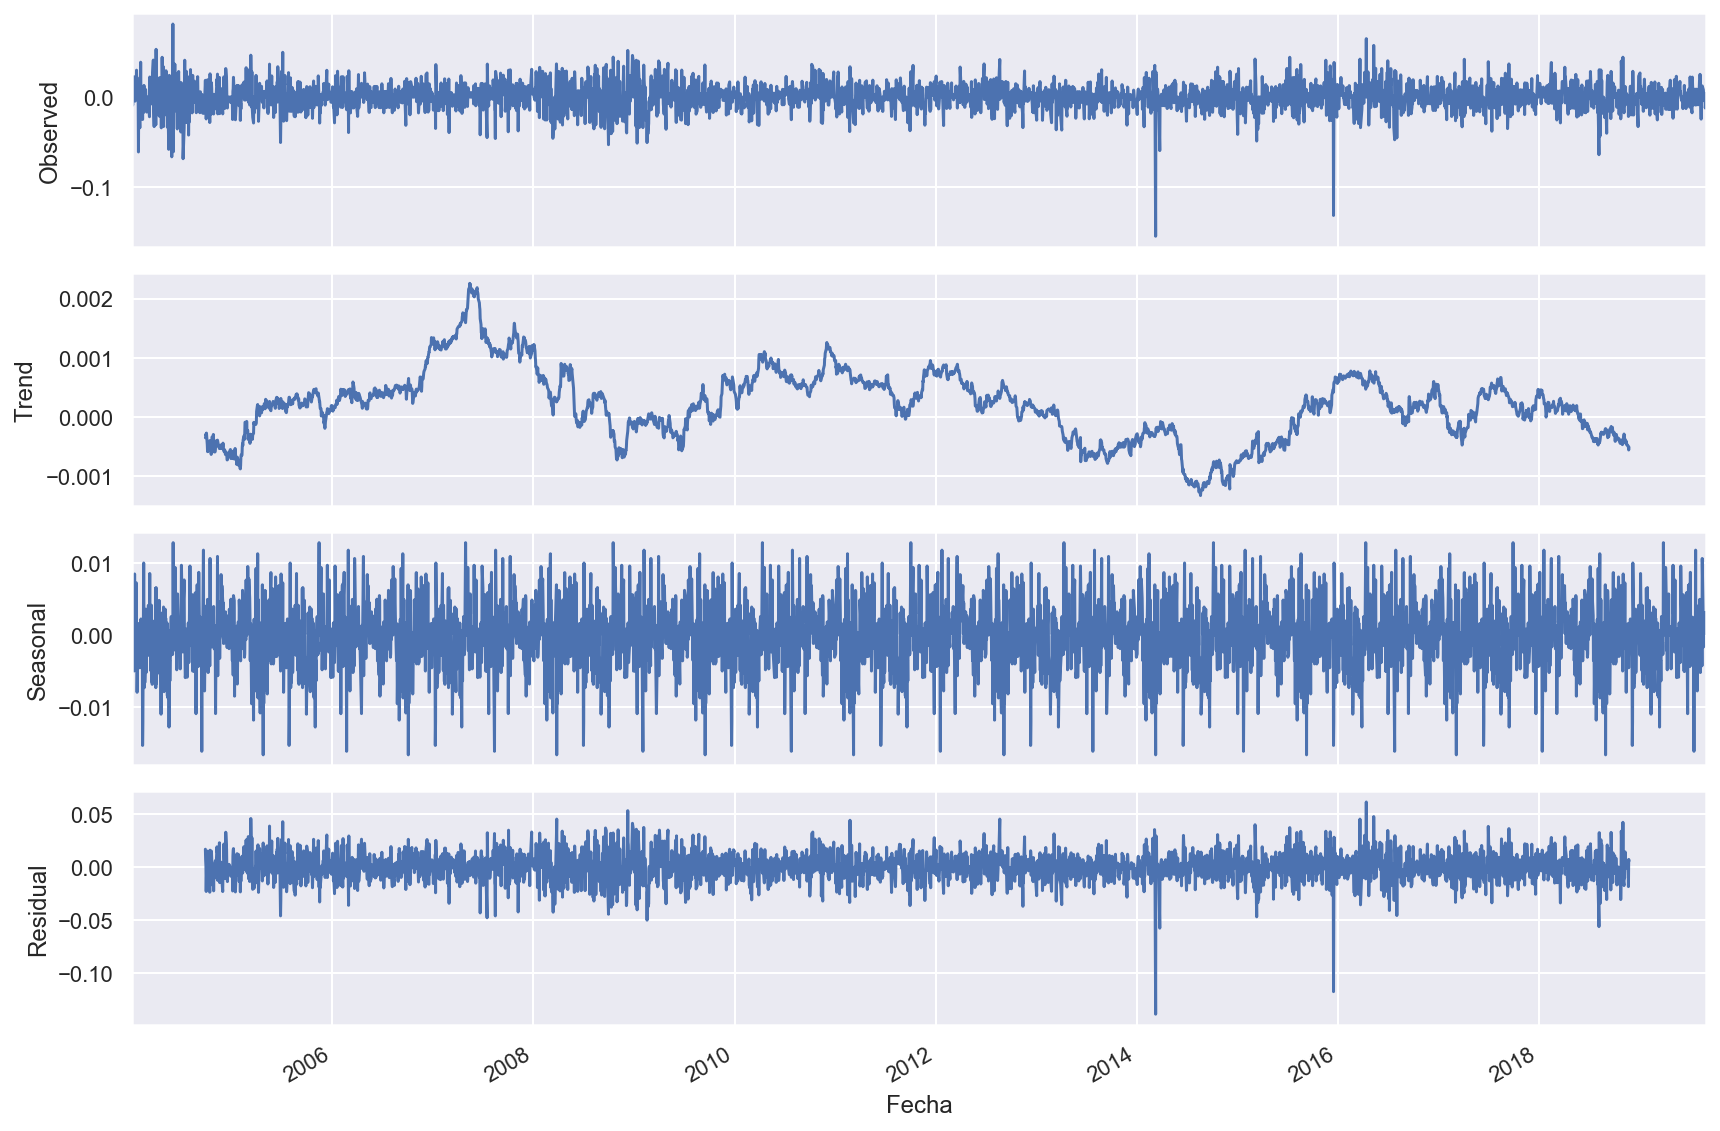

In [30]:
decomposition.plot();

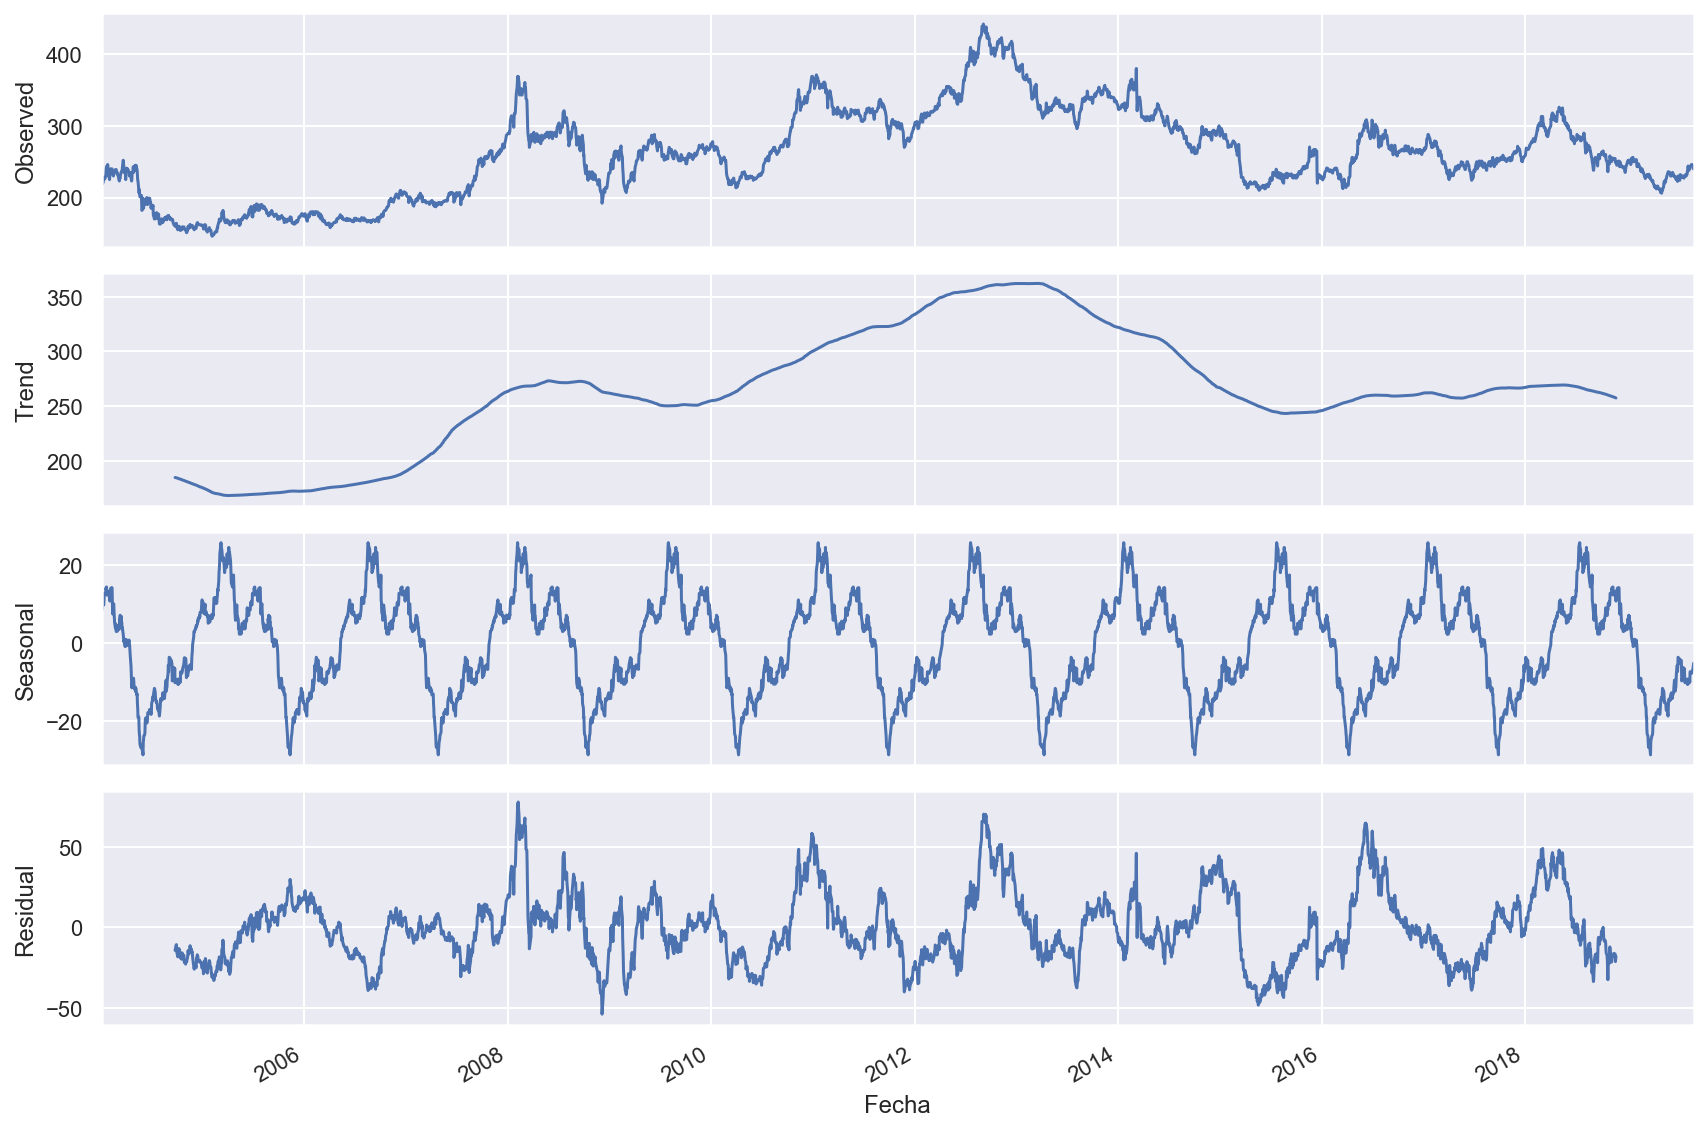

In [28]:
decomposition_cierre = sm.tsa.seasonal_decompose(df['Cierre'].dropna(), freq=365)
decomposition_cierre.plot();

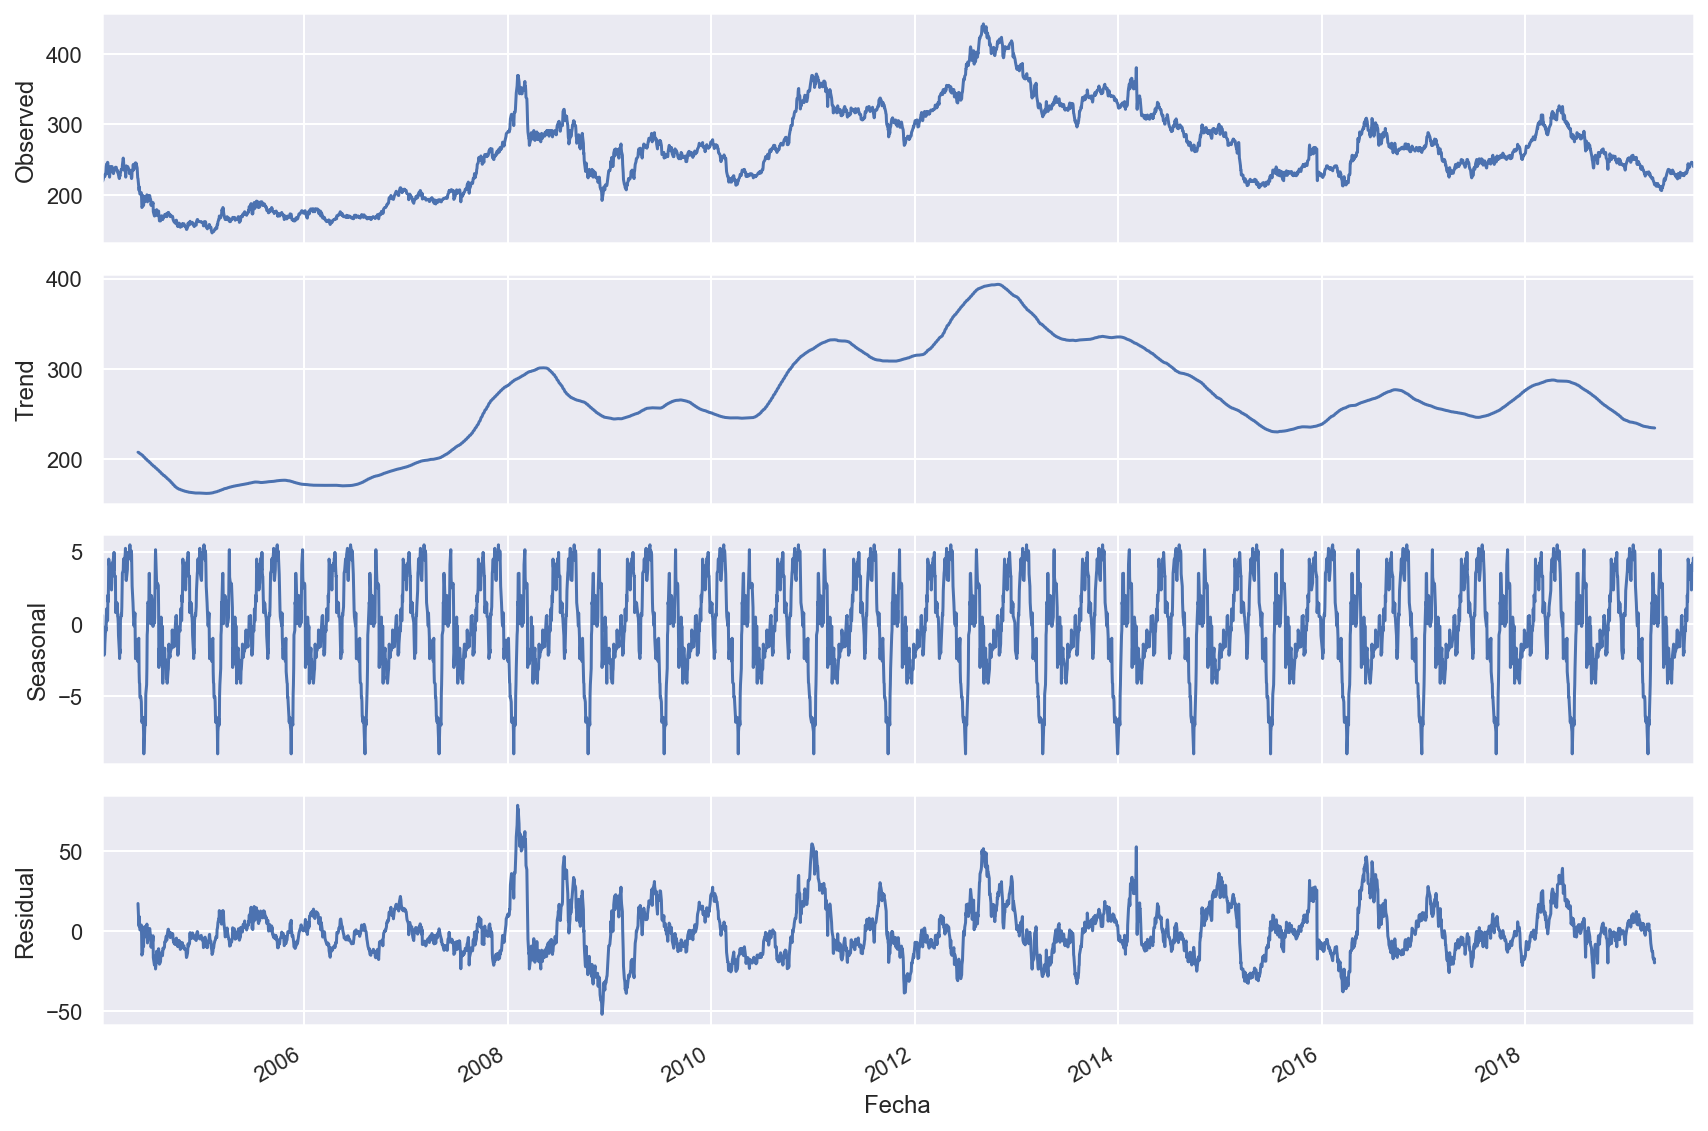

In [31]:
decomposition_half_year = sm.tsa.seasonal_decompose(df['Cierre'].dropna(), freq=182)
decomposition_half_year.plot();

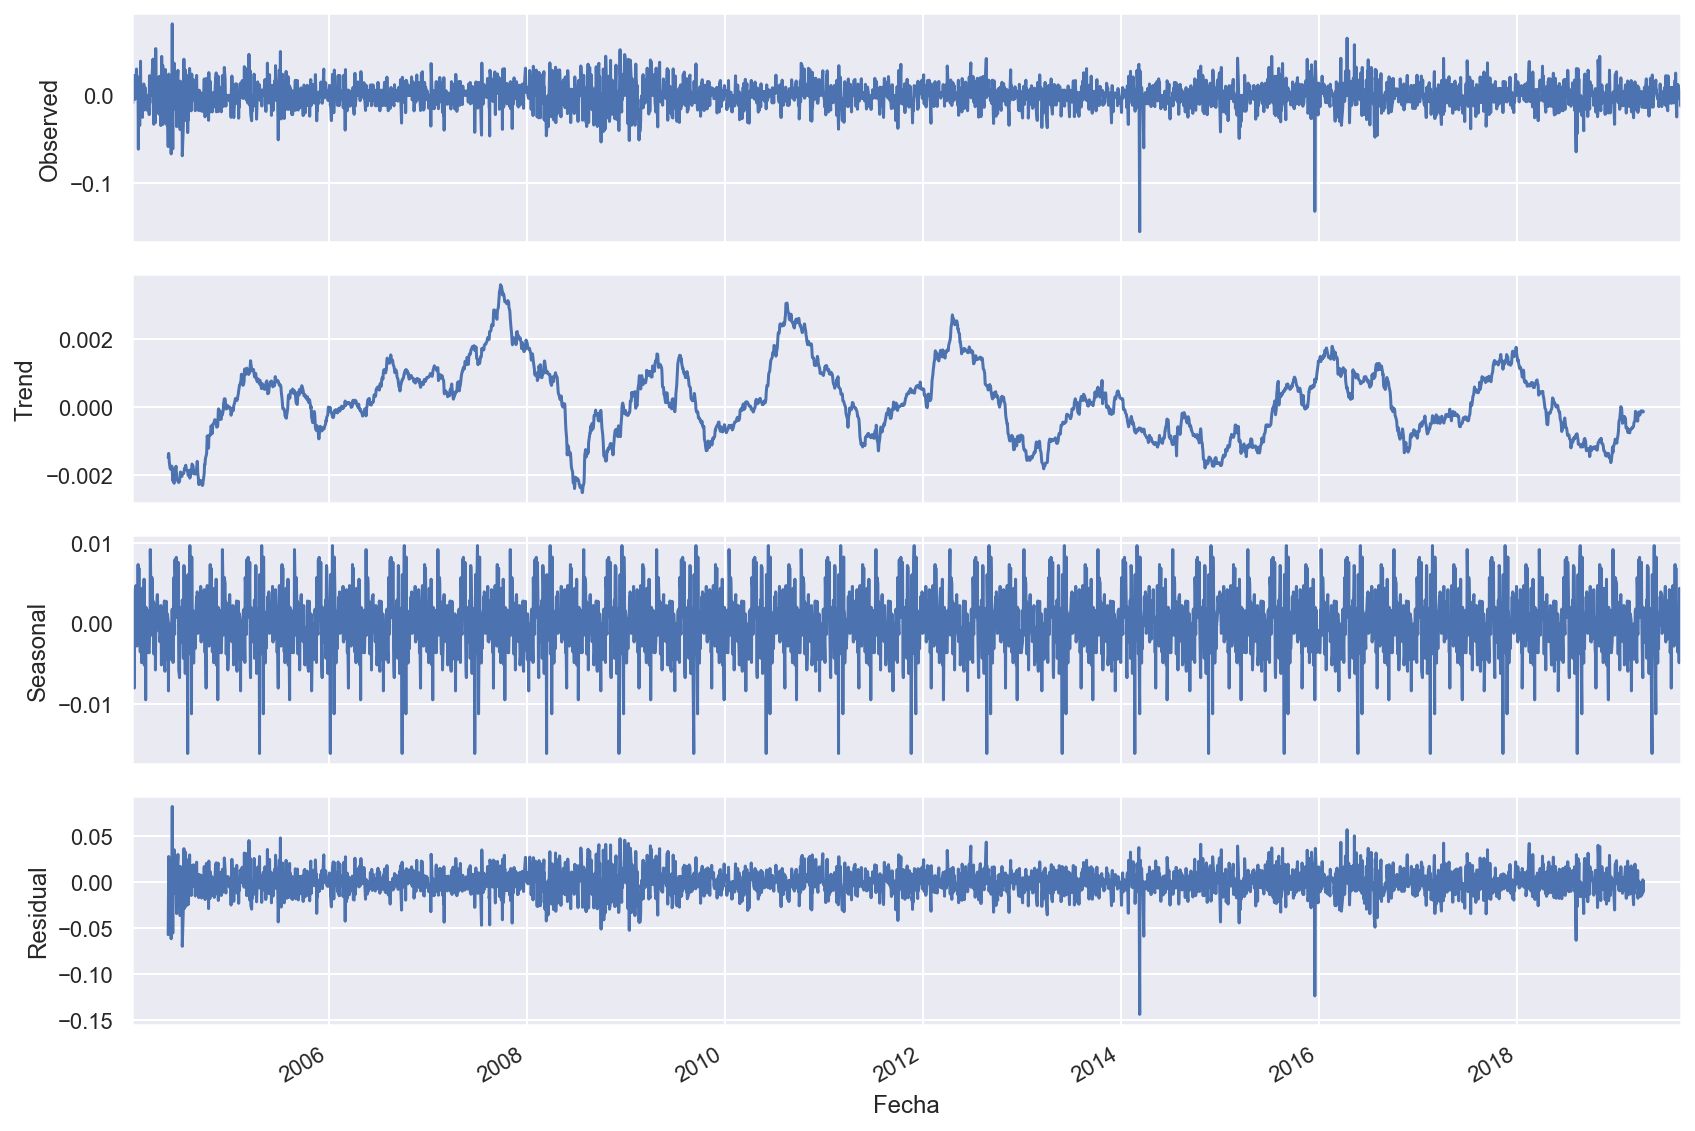

In [32]:
decomposition_half_year_ret = sm.tsa.seasonal_decompose(df['retorno'].dropna(), freq=182)
decomposition_half_year_ret.plot();

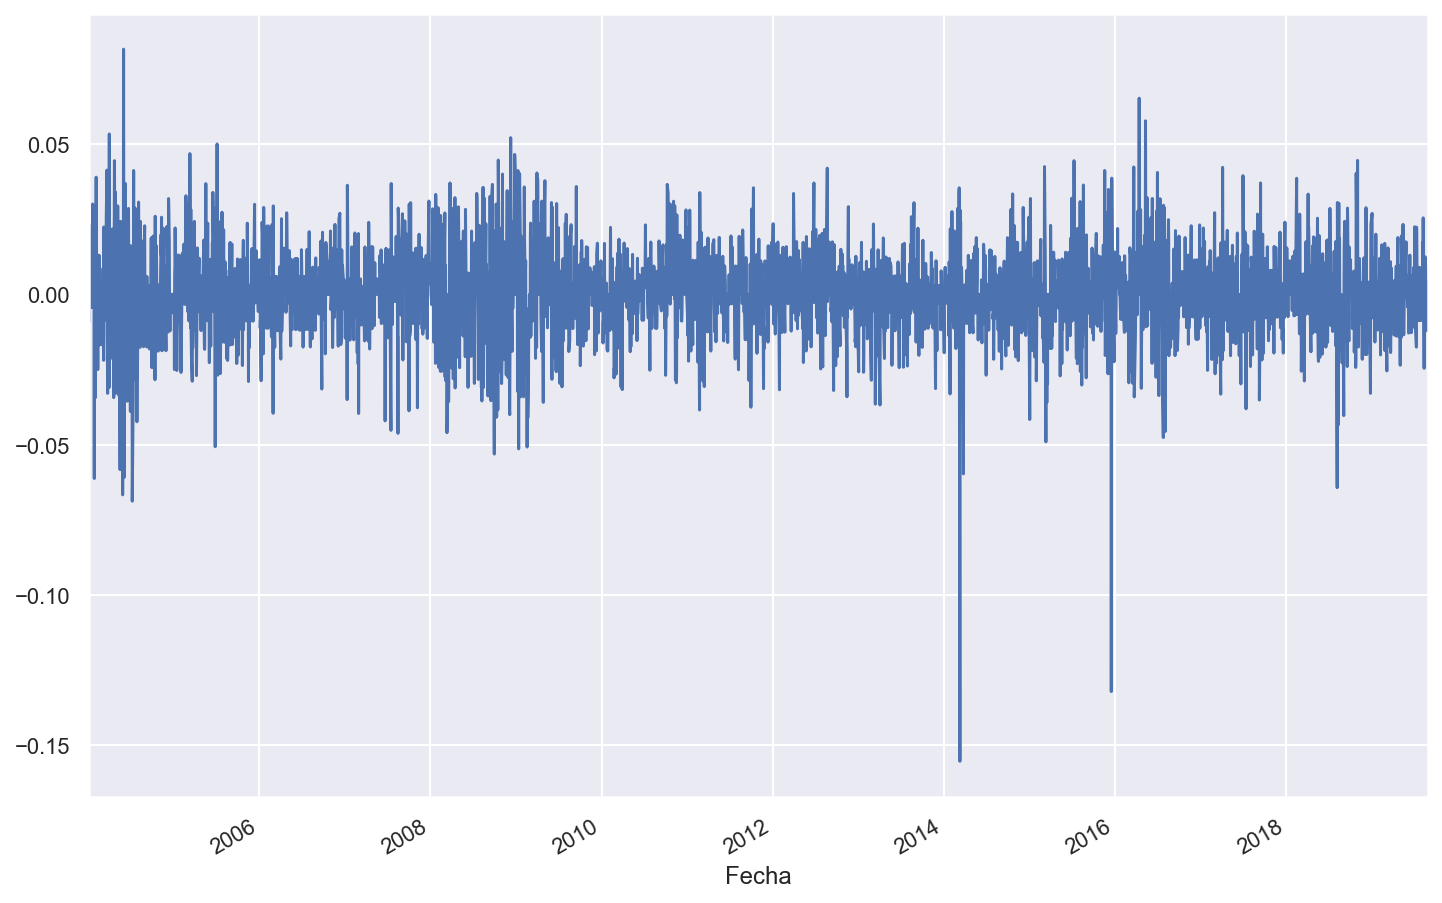

In [21]:
df['retorno'].plot();

In [33]:
from fbprophet import Prophet

In [36]:
md = Prophet()
data = pd.DataFrame({'ds': df.index, 'y': df['Cierre']})
md.fit(data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


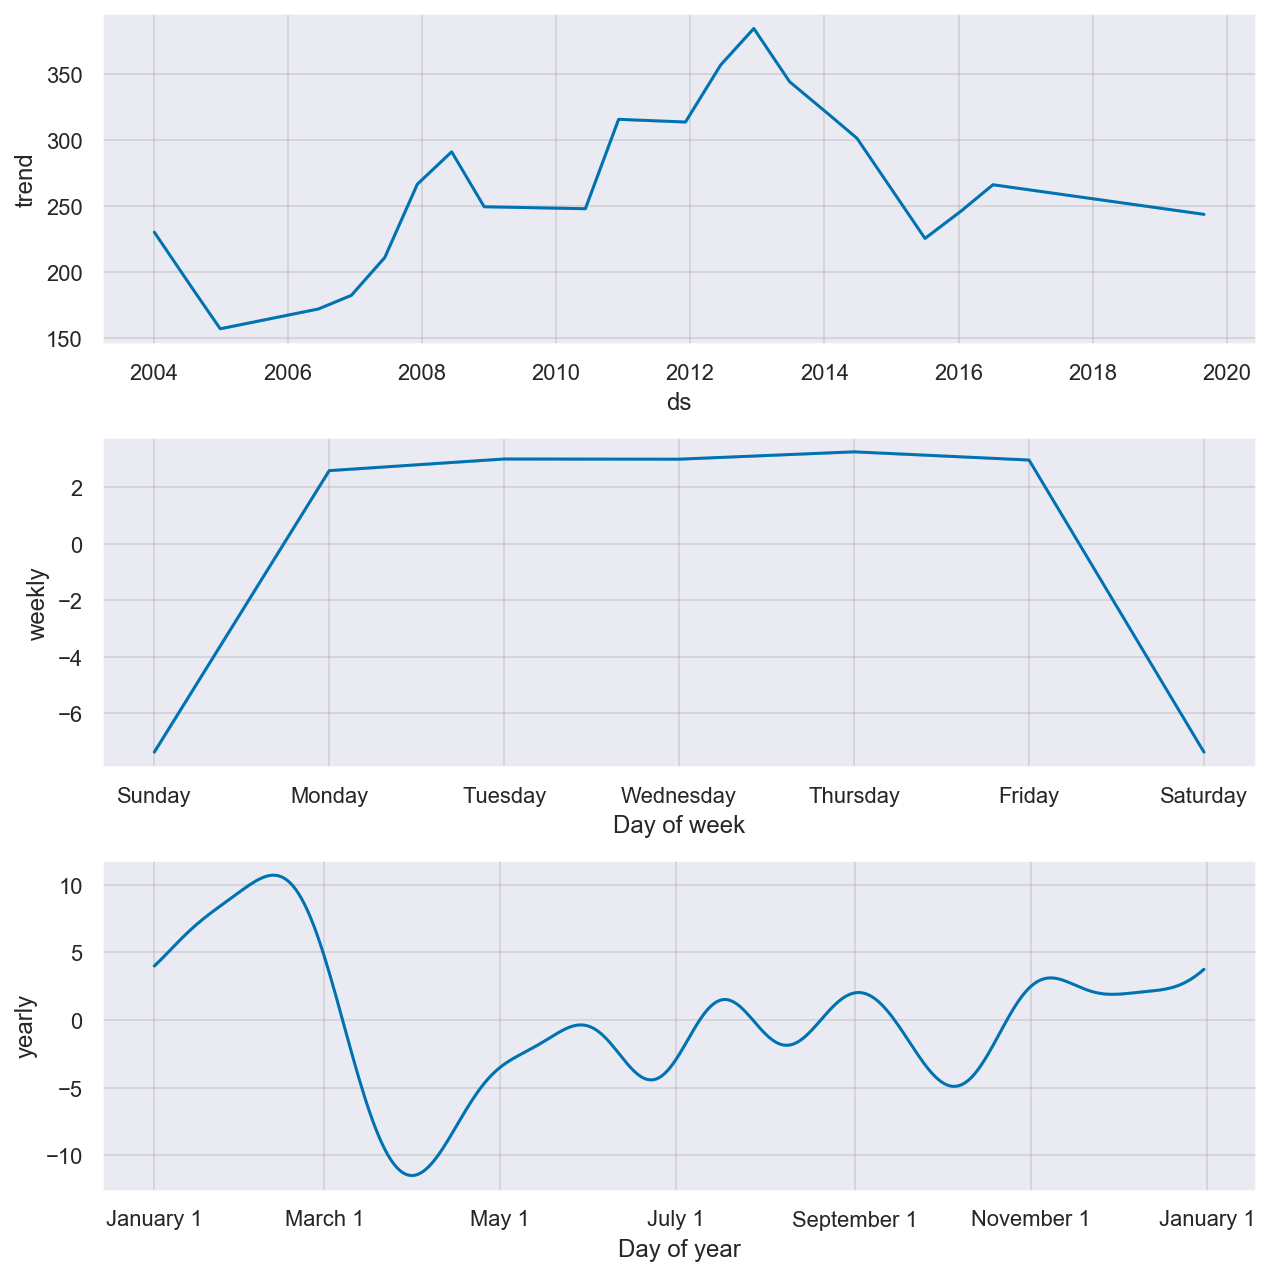

In [37]:
forecast = md.predict(data)
md.plot_components(forecast);

In [44]:
future = md.make_future_dataframe(periods=50)
future.tail()

,ds
3899,2019-10-14
3900,2019-10-15
3901,2019-10-16
3902,2019-10-17
3903,2019-10-18


In [47]:
fcast = md.predict(future)

In [48]:
fcast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3899,2019-10-14,242.934085,217.598501,266.552742,242.934085,242.934085,-1.121134,-1.121134,-1.121134,2.580146,2.580146,2.580146,-3.701279,-3.701279,-3.701279,0.0,0.0,0.0,241.812951
3900,2019-10-15,242.914609,213.574524,268.162331,242.914609,242.914609,-0.412350,-0.412350,-0.412350,2.992323,2.992323,2.992323,-3.404673,-3.404673,-3.404673,0.0,0.0,0.0,242.502259
3901,2019-10-16,242.895132,215.703289,268.078249,242.895132,242.895132,-0.097489,-0.097489,-0.097489,2.985593,2.985593,2.985593,-3.083082,-3.083082,-3.083082,0.0,0.0,0.0,242.797643
3902,2019-10-17,242.875656,216.599912,267.466607,242.831587,242.875656,0.505664,0.505664,0.505664,3.245450,3.245450,3.245450,-2.739787,-2.739787,-2.739787,0.0,0.0,0.0,243.381319
3903,2019-10-18,242.856179,217.480807,270.295631,242.791537,242.879129,0.577277,0.577277,0.577277,2.955631,2.955631,2.955631,-2.378354,-2.378354,-2.378354,0.0,0.0,0.0,243.433456


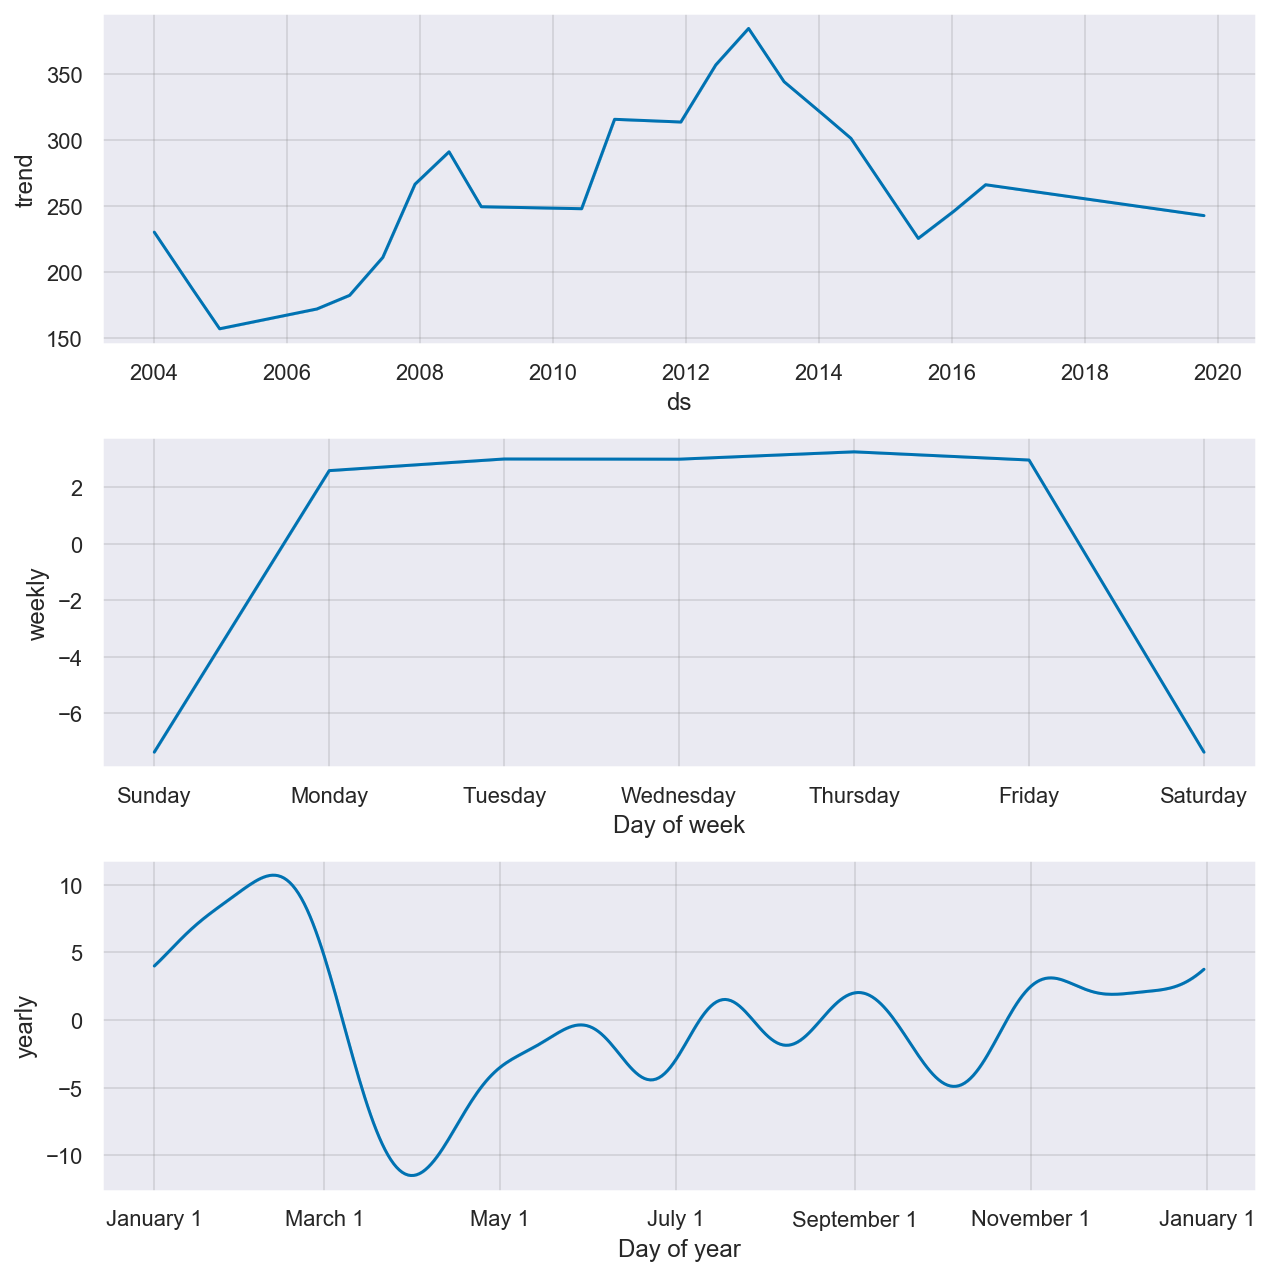

In [52]:
md.plot_components(fcast);

In [41]:
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 182)
mod_sarimax = sm.tsa.statespace.SARIMAX(df['retorno'][-600:], order=order, seasonal_order=seasonal_order)

In [42]:
mod_fit = mod_sarimax.fit()

KeyboardInterrupt: 

In [ ]:
predicted = mod_fit.forecast(10)

In [34]:
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 182)
mod_sarimax = sm.tsa.statespace.SARIMAX(df['retorno'], order=order, seasonal_order=seasonal_order)

In [35]:
mod_fit = mod_sarimax.fit()

KeyboardInterrupt: 

In [79]:
predicted = mod_fit.predict(start='2019-01-02', end='2019-08-29')

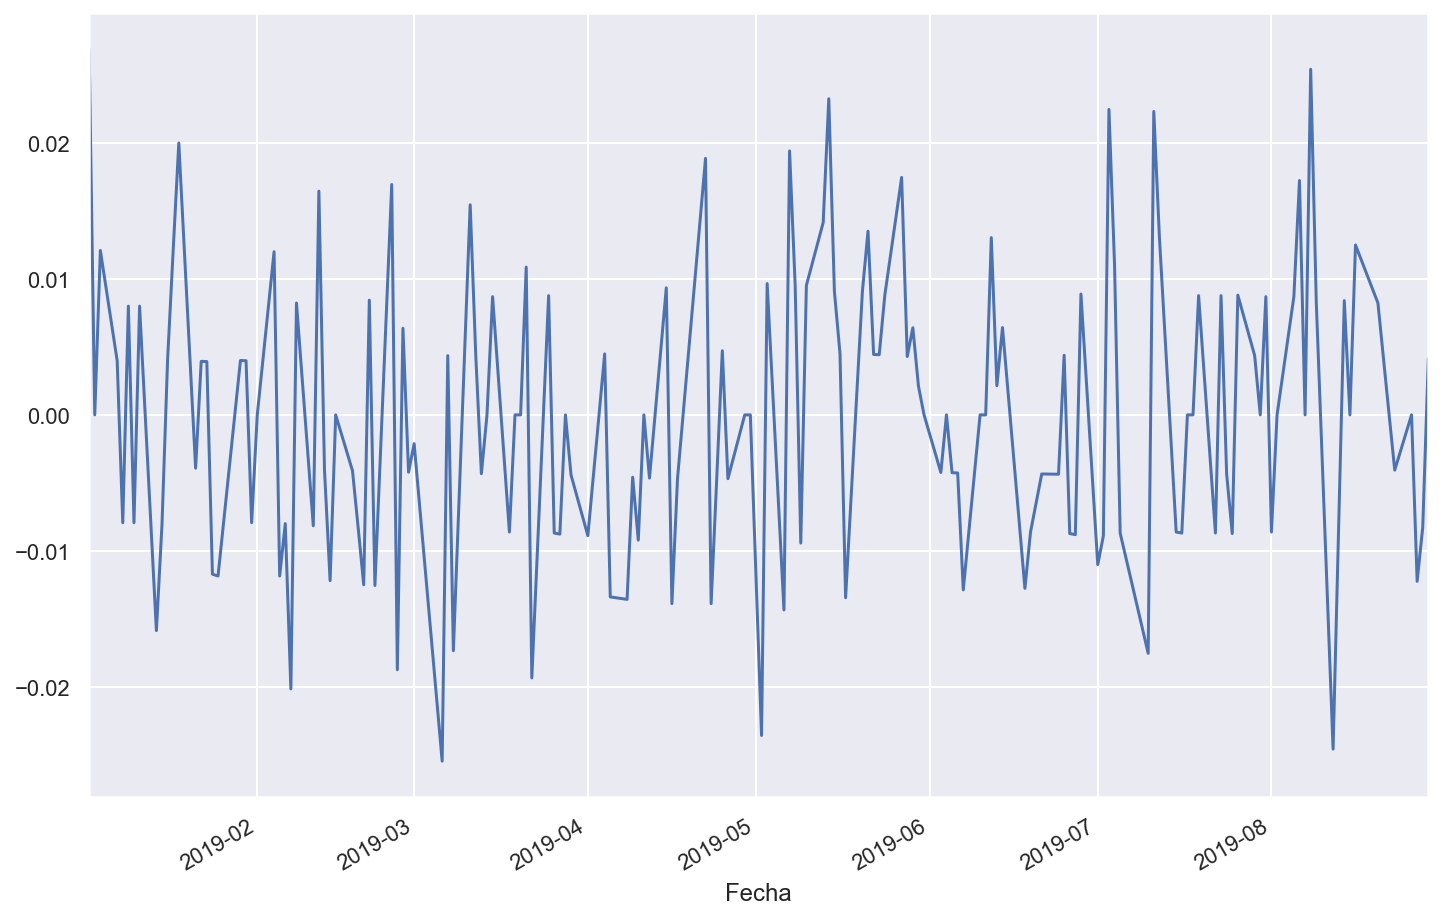

In [83]:
df.loc['2019-01-02':'2019-08-29', 'retorno'].plot()
# predicted.plot()

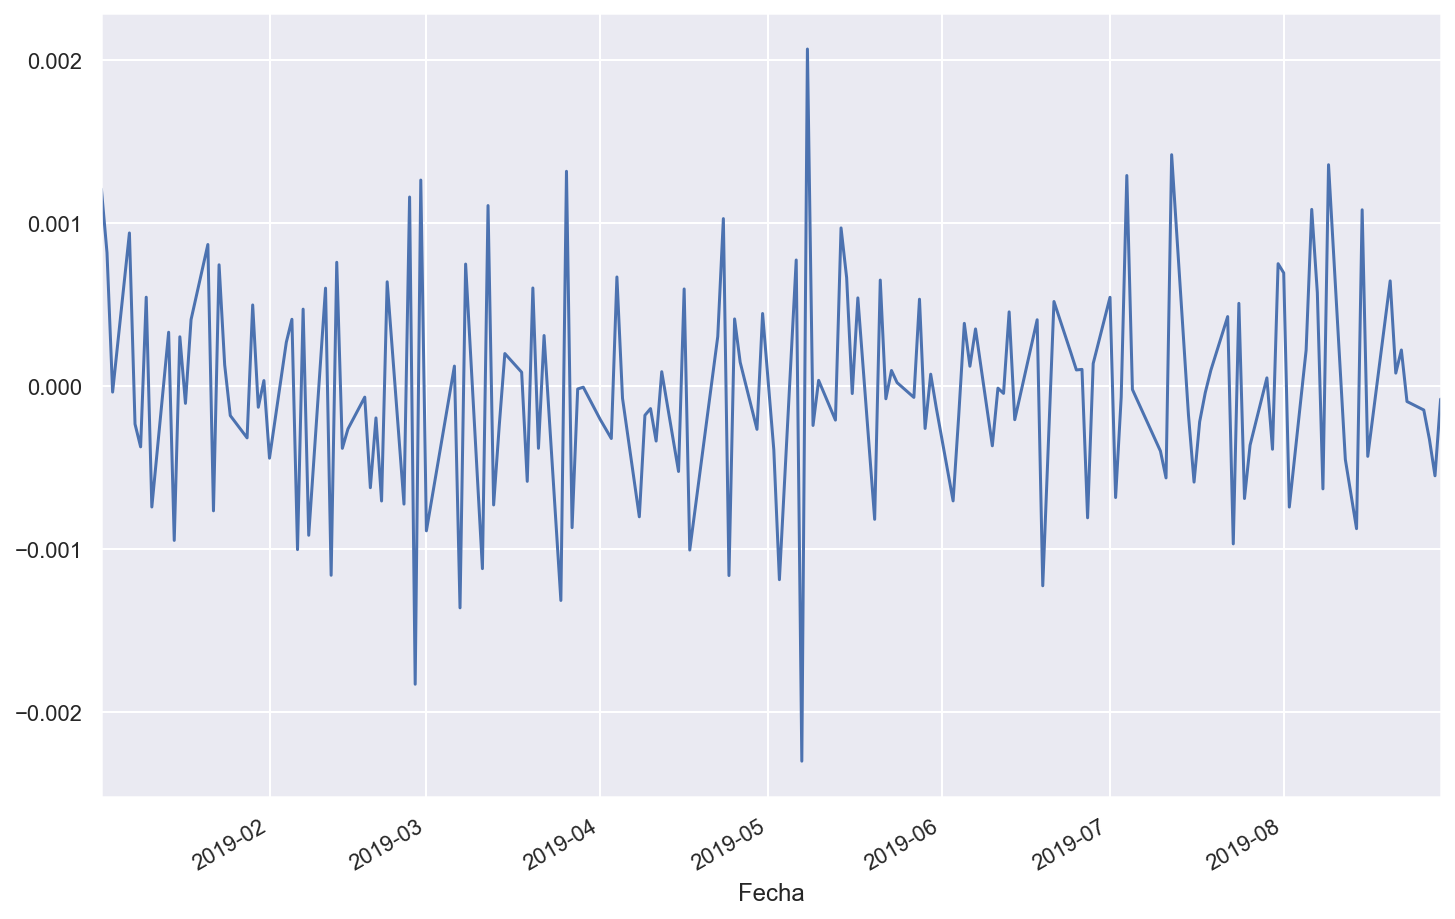

In [84]:
predicted.plot()

In [1]:
sm.tsa.graphics.plot_acf(mod_fit.resid.dropna());

NameError: name 'sm' is not defined

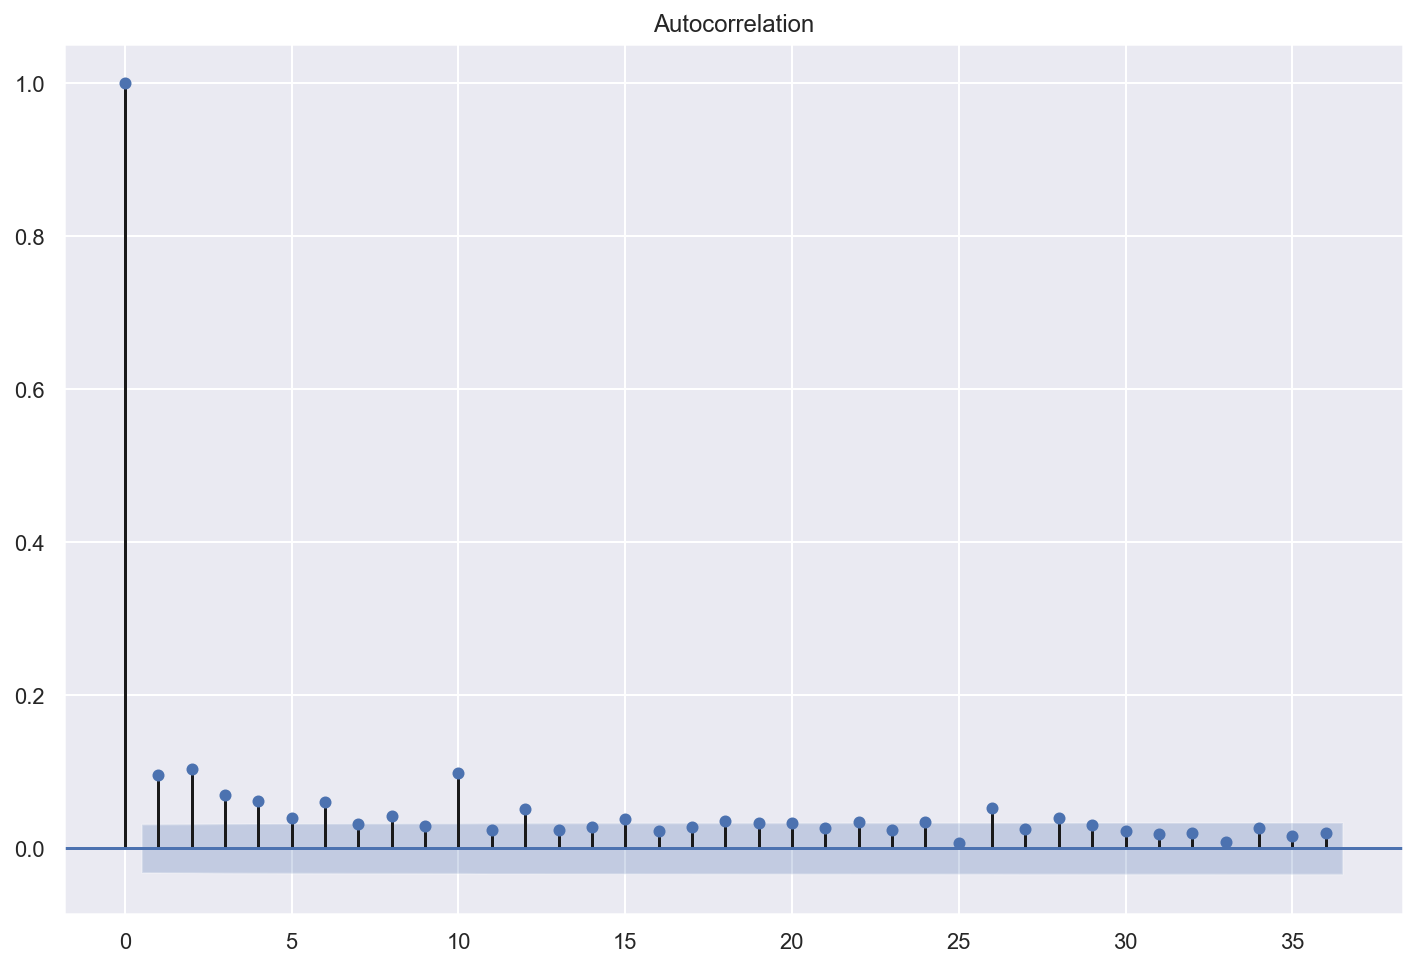

In [75]:
sm.tsa.graphics.plot_acf(mod_fit.resid.dropna() ** 2);

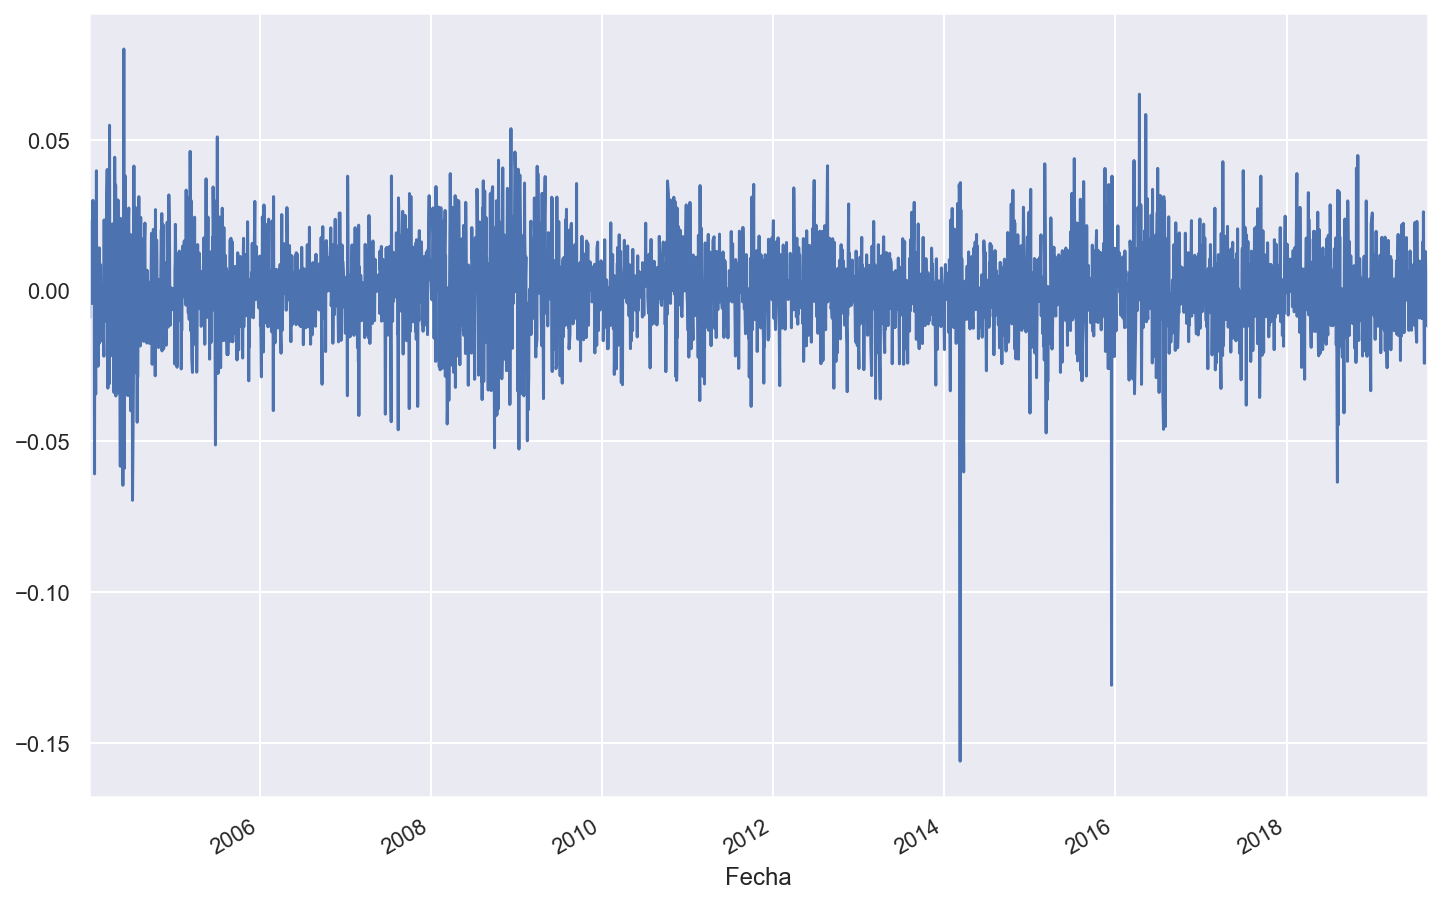

In [86]:
mod_fit.resid.plot()

In [88]:
mod_garch = pf.GARCH(mod_fit.resid.values, p=1, q=1)

In [91]:
garch_fit = mod_garch.fit('M-H')

Acceptance rate of Metropolis-Hastings is 0.00225
Acceptance rate of Metropolis-Hastings is 0.2082
Acceptance rate of Metropolis-Hastings is 0.2766

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.274625


In [92]:
garch_fit.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: 11167.5943            
End Date: 3853                                          AIC: -22327.188538691338                          
Number of observations: 3853                            BIC: -22302.162109312834                          
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Vol Constant                             0.0                0.0                (0.0 | 0.0)              
q(1)                                     0.

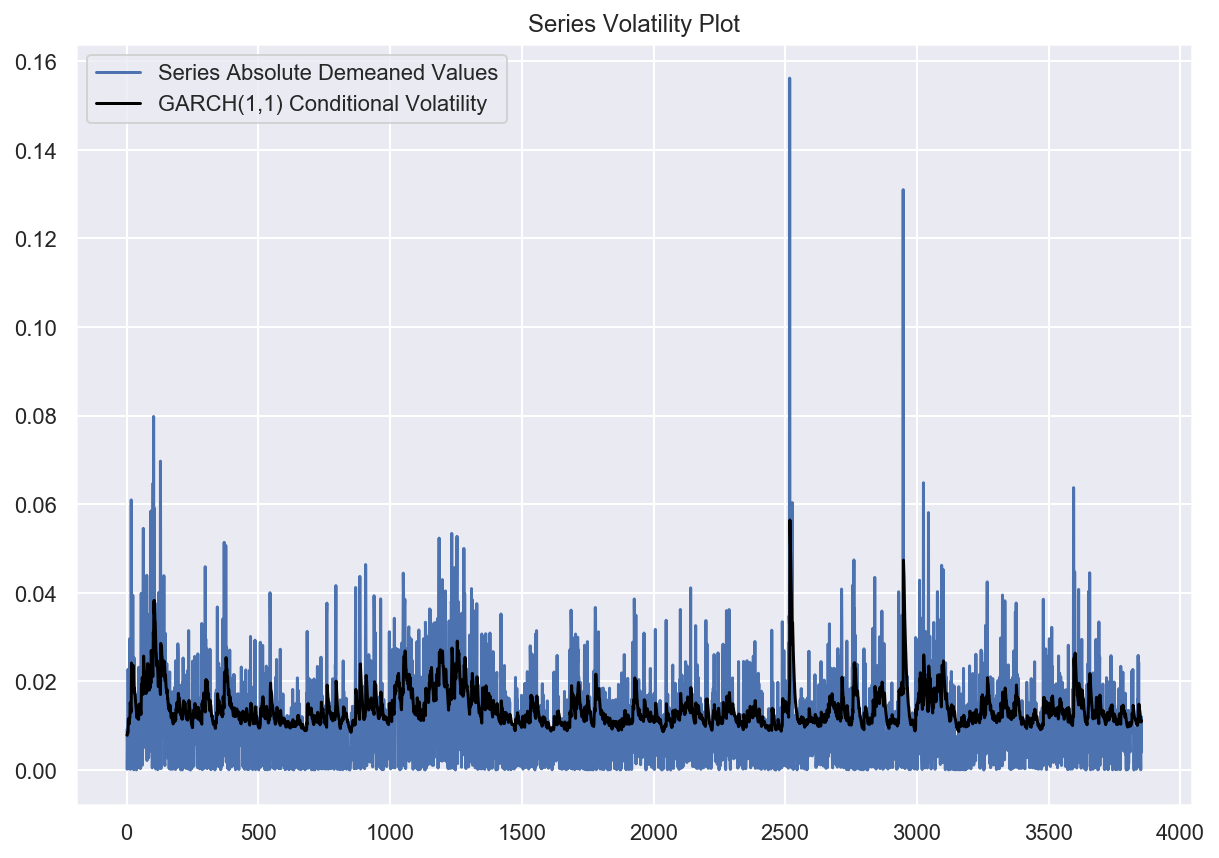

In [95]:
mod_garch.plot_fit()

In [96]:
mod_garch.predict(10)

,Series
3854,0.000115
3855,0.000129
3856,0.000143
3857,0.000154
3858,0.000162
3859,0.000170
3860,0.000176
3861,0.000182
3862,0.000186
3863,0.000190


In [119]:
arma_garch = mod_fit.predict(start=len(df['retorno']), end=len(df['retorno']) + 9) + mod_garch.predict(10)['Series']

In [131]:
last = df.iloc[-1]['Cierre']

In [136]:
shifted = (arma_garch + 1)

In [137]:
shifted

3854    0.999991
3855    1.000174
3856    1.000411
3857    1.000133
3858    1.000254
3859    0.999810
3860    1.000175
3861    0.999964
3862    1.000710
3863    0.999823
dtype: float64

In [138]:
type(shifted)

pandas.core.series.Series

In [142]:
dff = pd.DataFrame(shifted)

In [146]:
dff.columns = ['ret']

In [149]:
dff

,ret
3854,0.999991
3855,1.000174
3856,1.000411
3857,1.000133
3858,1.000254
3859,0.999810
3860,1.000175
3861,0.999964
3862,1.000710
3863,0.999823


In [150]:
dff['predicted'] = dff['ret'].cumprod()

In [154]:
prices = dff['predicted'] * last

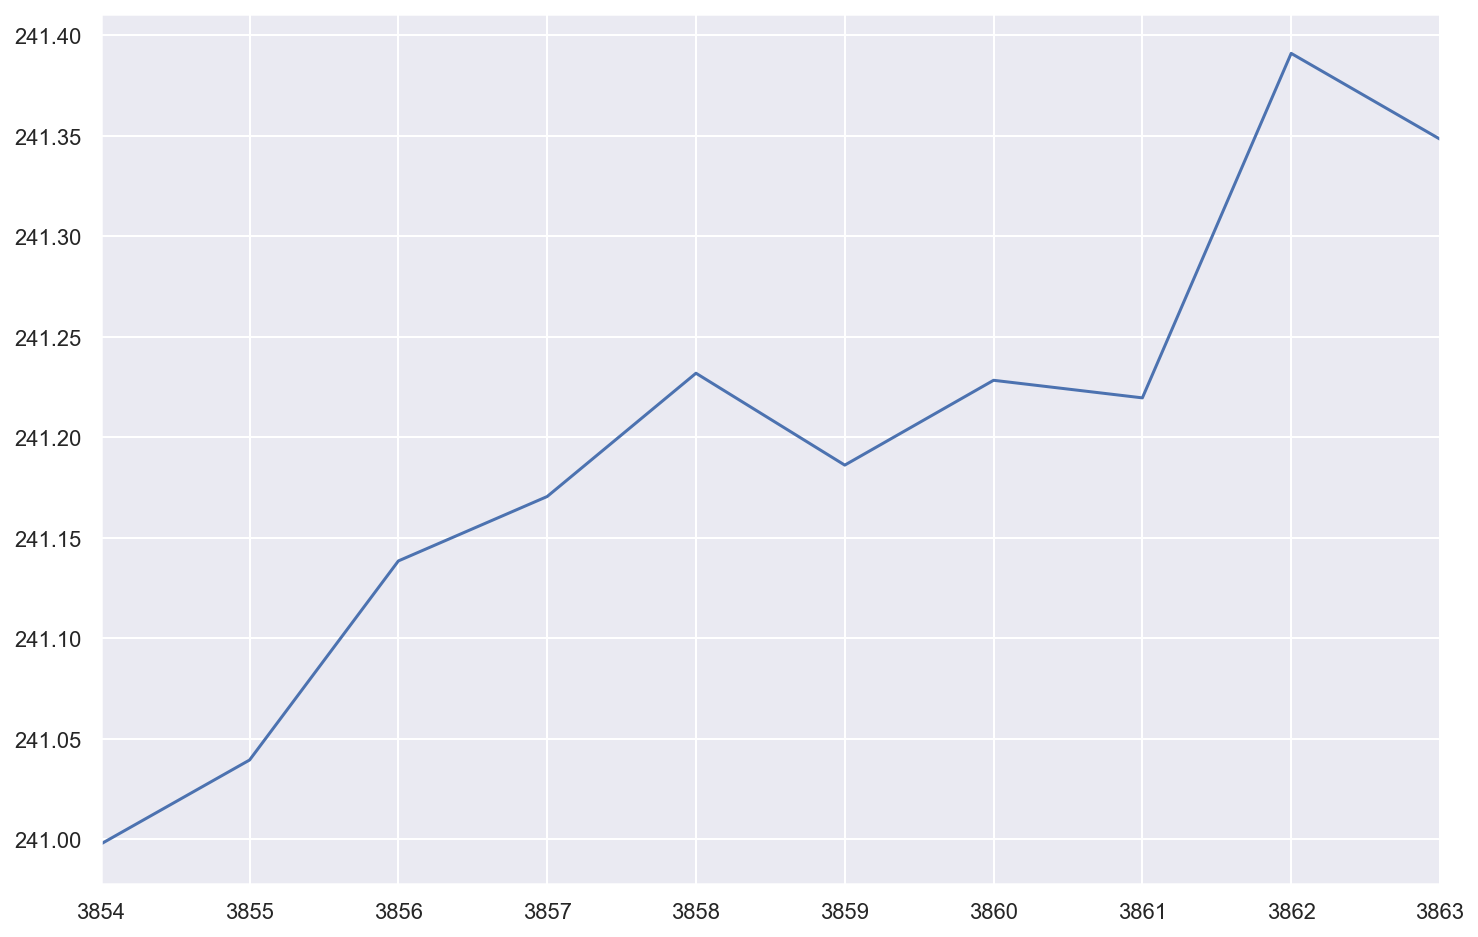

In [155]:
prices.plot()

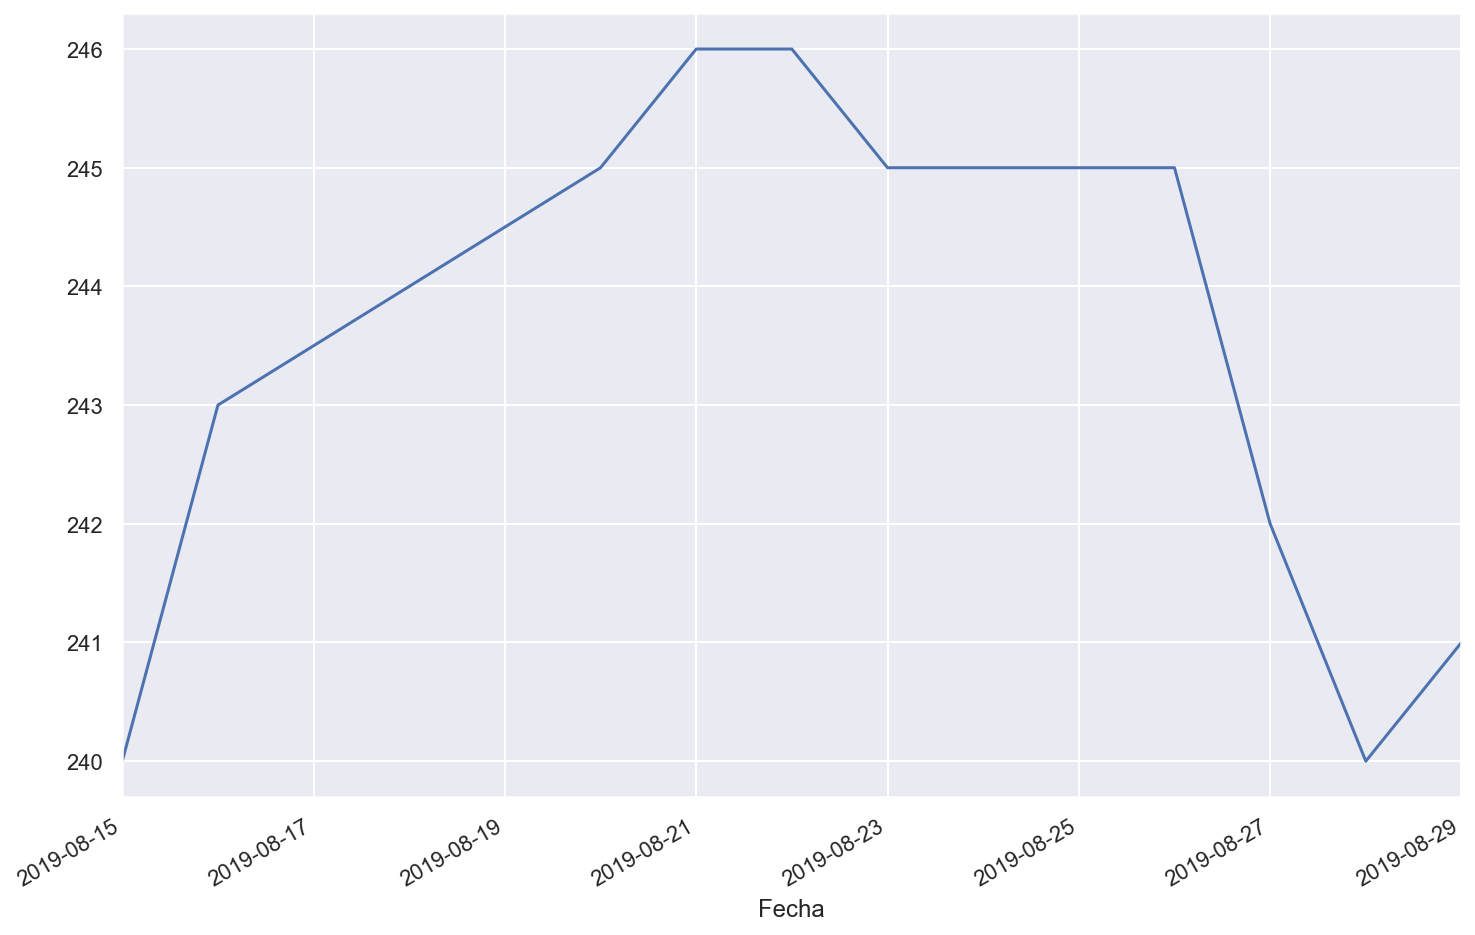

In [135]:
df['Cierre'].tail(10).plot()